In [1]:
from funlib.persistence import open_ds
from funlib.geometry import Roi
import numpy as np
from scipy.ndimage import binary_erosion

nucleus = open_ds(
    "/nrs/cellmap/ackermand/cellmap/jrc_mus-liver-zon-1.n5", "nucleus", mode="r"
)

offset = np.array([24032, 11092, 10582])
dimension = np.array([1470, 1598, 1934])
nucleus = nucleus.intersect(Roi(offset * 8, dimension * 8))
nucleus.materialize()
nucleus.data = nucleus.data == 969
surface = nucleus.data ^ binary_erosion(nucleus.data)

print(np.sum(nucleus.data[:]))

108640170


True

In [2]:
import itertools


def get_surface_counts(n, s):
    totes = np.zeros_like(s, dtype=int)
    xs, ys, zs = np.nonzero(s[1:-1, 1:-1, 1:-1])
    xs = xs + 1
    ys = ys + 1
    zs = zs + 1
    for x, y, z in zip(xs, ys, zs):
        voxel_face_counts = 0
        for dx, dy, dz in list(itertools.product(range(-1, 2), repeat=3)):
            if dx == dy == 0 or dz == dy == 0 or dz == dx == 0:
                if n[x + dx, y + dy, z + dz] == 0:
                    voxel_face_counts = voxel_face_counts + 1
        totes[x, y, z] = voxel_face_counts
    return totes


totes = get_surface_counts(nucleus.data, surface)

In [18]:
np.sum(surface)

944251

In [ ]:
data = nucleus.data == 969

In [ ]:
del nucleus

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, distance_transform_edt

surface = data ^ binary_erosion(data)
plt.imshow(surface[300,...])
for x,y,z in nuclear_pore_image:
    if nuclear_pore_image[z,y,x] >0:
        if surface[z//2,y//2,x//2] > 0:
            # this nuclear  pore voxel is on the surface of teh nucleus
            # keep count

nuclear_pore_surface_voxels / num_surface_voxels

# think of it in nm: if youre at (100,50,20) voxel coordinate at 8 nm resolution, you are at position (800 nm, 400 nm, 160 nm).
# but now at 16 nm resolution, you would be at voxel (800 nm/16nm, 400 nm/16nm, 160 nm/16nm) = (50, 25, 10)

In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion, distance_transform_edt

eroded = 1 - data ^ binary_erosion(data)
distances = distance_transform_edt(eroded, return_distances=True)

In [ ]:
valid_voxels = distances < 15

In [ ]:
import pandas as pd

df = pd.read_csv("/nrs/cellmap/ackermand/forHannah/fragments_relabeled.csv")
len(df[df["Volume (nm^3)"] > 512 * 1000])

In [ ]:
com_z, com_y, com_x = df["COM Z (nm)"], df["COM Y (nm)"], df["COM X (nm)"]
# divide by 16 to get in nucleus voxel space
com_z = (com_z - offset[0]) // 16
com_y = (com_y - offset[1]) // 16
com_x = (com_x - offset[2]) // 16
volume = df["Volume (nm^3)"]
ids = df["Object ID"]

ids_to_keep = []
for id, z, y, x, v in zip(ids, com_z, com_y, com_x, volume):
    try:
        if valid_voxels[int(z), int(y), int(x)] and v > 512 * 1000:
            ids_to_keep.append(str(id))
    except:
        pass

In [ ]:
",".join(ids_to_keep)

In [ ]:
len(ids_to_keep)

In [ ]:
com_x.max(), com_z.max()

In [ ]:
fragments = open_ds(
    "/nrs/cellmap/nguyenh3/cellmap/predictions/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
    "processed/2023-07-07/nuclear_pores_affs_lsds/0/fragments_relabeled/",
    mode="r",
)
id_to_counts_dict = {}
from tqdm import tqdm

for chunk_z in tqdm(list(range(0, 1250, 250))):
    for chunk_y in range(0, 1350, 250):
        for chunk_x in range(0, 1750, 250):
            current_chunk = fragments.intersect(
                Roi(
                    offset + np.array((chunk_z * 8, chunk_y * 8, chunk_x * 8)),
                    np.array((250 * 8, 250 * 8, 250 * 8)),
                )
            )
            current_chunk.materialize()
            current_chunk = current_chunk.data[:]
            print(current_chunk.shape)
            current_valid_voxels = valid_voxels[
                int(chunk_z // 2) : int(chunk_z // 2) + 125,
                int(chunk_y // 2) : int(chunk_y // 2) + 125,
                int(chunk_x // 2) : int(chunk_x // 2) + 125,
            ]
            ids, counts = np.unique(
                current_valid_voxels * current_chunk, return_counts=True
            )
            for id, count in zip(ids, counts):
                if id not in id_to_counts_dict:
                    id_to_counts_dict[id] = count
                else:
                    id_to_counts_dict[id] = id_to_counts_dict[id] + count

In [ ]:
fragments = open_ds(
    "/nrs/cellmap/nguyenh3/cellmap/predictions/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
    "processed/2023-07-07/nuclear_pores_affs_lsds/0/fragments_relabeled/",
    mode="r",
)
# id_to_centers_dict = {}
from tqdm import tqdm

for chunk_z in tqdm(list(range(1250, 1500, 250))):  # tqdm(list(range(0, 1250, 250))):
    for chunk_y in range(1350, 1600, 250):  # range(0, 1350, 250):
        for chunk_x in range(1750, 2000, 250):  # range(0, 1750, 250):
            print((chunk_z, chunk_y, chunk_x))
            current_chunk = fragments.intersect(
                Roi(
                    offset + np.array((chunk_z * 8, chunk_y * 8, chunk_x * 8)),
                    np.array((250 * 8, 250 * 8, 250 * 8)),
                )
            )
            current_chunk.materialize()
            current_chunk = current_chunk.data[:]
            ids, counts = np.unique(
                current_chunk[current_chunk > 0], return_counts=True
            )
            for id, count in zip(ids, counts):
                z, y, x = np.nonzero(current_chunk == id)
                if id not in id_to_centers_dict:
                    id_to_centers_dict[id] = (count, np.sum(z), np.sum(y), np.sum(x))
                else:
                    id_to_centers_dict[id] = (
                        count + id_to_centers_dict[id][0],
                        np.sum(z) + id_to_centers_dict[id][1],
                        np.sum(y) + id_to_centers_dict[id][2],
                        np.sum(x) + id_to_centers_dict[id][3],
                    )

In [ ]:
np.sum(x) + id_to_centers_dict[id][x]

In [ ]:
nz_z, nz_y, nz_x = np.nonzero(valid_voxels)

In [ ]:
valid_voxels

In [ ]:
nz = np.column_stack((nz_z, nz_y, nz_x)) > 0

In [ ]:
nz_chunks = np.floor((nz * 16 + np.array(offset)) / (256 * 8))

In [ ]:
from tqdm import tqdm

chunk_offsets = set()
for row in tqdm(nz):
    chunk_offsets.add(tuple((row // (256 * 8)).astype(np.uint16)))

In [ ]:
nz_chunk_start = (nz // (256 * 8)).astype(np.uint16)
nz_tuples = tuple(map(tuple, nz_chunk_start))

In [ ]:
nz_unique_chunks = np.unique((nz // (256 * 8)).astype(np.uint8), axis=0)

In [ ]:
24032 * 8 // (256 * 8)

In [ ]:
from funlib.persistence import open_ds
from funlib.geometry import Roi

fragments = open_ds(
    "/nrs/cellmap/nguyenh3/cellmap/predictions/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
    "processed/2023-07-07/nuclear_pores_affs_lsds/0/fragments_relabeled/",
    mode="r",
)
offset = (24032 * 8, 11092 * 8, 10582 * 8)
dimension = (1470 * 8, 1598 * 8, 1934 * 8)
# fragments = fragments.intersect(Roi(offset, dimension))

In [ ]:
fragments.data[1, 1, 1]

In [ ]:
fragments.materialize()

1. calculate the centers of the annotations --> ground truth positives
2. 
from funlib.persistence import open_ds
from funlib.geometry import Roi
fragments = open_ds(
    "/nrs/cellmap/nguyenh3/cellmap/predictions/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
    "processed/2023-07-07/nuclear_pores_affs_lsds/0/fragments_relabeled/",
    mode="r",
)
offset = (your_offset_in_nm)
dimension = (your_dimension_in_nm)
fragments = fragments.intersect(Roi(offset, dimension))
3. for each annotation center:
    # true positives and false negatives
    nuclear_pore_id = fragments.data[annotation_center_z,annotation_center_y,annotation_center_x]
    if nuclear_pore_id>0:
        true positives +=1 
        positive_pores.add(nuclear_pore_id: count)
    otherwise:
        false negatives += 1
        annotation_lcoations.add(annotation_location)
# false positives (and true negatives)
false positives = difference between set(all_pores) and set(positive_pores)

    
    

In [ ]:
valid_pores_5 = [
    2151677954,
    2151677955,
    2151677959,
    2151677965,
    2151677967,
    2164260865,
    2164260866,
    2164260868,
    2164260874,
    2164260875,
    2164260879,
    2164260880,
    2164260881,
    6469713953,
    6469713958,
    6467616776,
    6467616779,
    6467616778,
    6469713967,
    6469713966,
    2174746626,
    2174746628,
    6469713925,
    2174746630,
    6469713927,
    2174746631,
    6469713926,
    2174746632,
    2174746633,
    6469713928,
    2174746634,
    2174746635,
    2174746636,
    2174746639,
    6469713934,
    2174746640,
    2174746641,
    6469713936,
    2174746642,
    2174746645,
    6469713946,
    6469713949,
    6469713948,
    6469713950,
    6473908257,
    6473908256,
    6473908259,
    6473908258,
    6471811077,
    6471811076,
    6471811078,
    6471811082,
    6471811085,
    6471811089,
    6471811091,
    6471811090,
    6471811096,
    6471811103,
    6471811102,
    6473908225,
    6473908227,
    6473908230,
    6473908232,
    6473908238,
    6473908241,
    6473908240,
    6473908243,
    6473908245,
    6473908244,
    6473908247,
    6473908249,
    6473908251,
    6473908250,
    6473908253,
    6473908252,
    6473908255,
    6473908254,
    6476005381,
    6476005382,
    6476005389,
    6476005388,
    6476005391,
    6476005393,
    6476005392,
    6476005395,
    6476005394,
    6476005396,
    2187329537,
    2187329545,
    2187329546,
    2187329547,
    2187329548,
    2187329551,
    2187329555,
    2187329556,
    2202009602,
    2202009603,
    2202009605,
    2202009606,
    2202009607,
    2202009609,
    2202009610,
    2202009611,
    2202009612,
    2202009614,
    2212495361,
    2212495362,
    2212495364,
    2212495366,
    2212495367,
    2212495369,
    2212495371,
    2212495372,
    2212495373,
    2212495377,
    2212495390,
    6509559813,
    6509559815,
    6509559814,
    6509559817,
    6509559816,
    6509559819,
    6509559831,
    6509559836,
    6509559839,
    6509559840,
    6509559842,
    6511656969,
    6511656973,
    6511656974,
    6511656977,
    6511656979,
    6511656978,
    6511656980,
    4368367619,
    4368367621,
    4368367620,
    4368367622,
    4368367624,
    4368367627,
    4368367626,
    4370464771,
    4370464770,
    4370464772,
    4370464774,
    4370464781,
    4370464782,
    4370464784,
    4370464793,
    4370464795,
    4370464794,
    4370464797,
    4370464799,
    4372561921,
    2231369731,
    2231369733,
    2231369734,
    2231369735,
    2231369737,
    2231369738,
    2231369739,
    2231369740,
    2231369741,
    2231369743,
    2231369744,
    2231369745,
    2231369746,
    2231369747,
    2231369748,
    2231369750,
    2231369751,
    2231369753,
    2231369755,
    2231369756,
    2231369759,
    2239758338,
    2239758342,
    2239758345,
    2239758347,
    2239758348,
    2239758349,
    2239758350,
    2239758357,
    2239758358,
    2239758359,
    2239758361,
    2239758362,
    2239758363,
    2239758364,
    2239758365,
    2239758366,
    2239758367,
    2239758368,
    2239758369,
    4389339147,
    4391436293,
    4391436295,
    4391436294,
    4391436297,
    4391436296,
    4391436301,
    4391436300,
    4391436302,
    4391436308,
    4395630595,
    4395630598,
    4397727747,
    4397727749,
    4397727748,
    4397727753,
    4397727755,
    4397727754,
    4397727757,
    4397727759,
    4397727761,
    2262827009,
    2264924162,
    2264924168,
    2264924169,
    2264924170,
    2264924171,
    2264924173,
    2264924174,
    2264924175,
    2264924177,
    2264924178,
    2264924179,
    2267021313,
    2267021314,
    2267021316,
    2267021317,
    4414504967,
    2267021318,
    4414504966,
    4414504969,
    4414504970,
    2267021324,
    4414504974,
    4414504976,
    2267021329,
    2267021331,
    2267021333,
    2267021334,
    2267021335,
    2269118465,
    4424990723,
    4424990722,
    4424990724,
    4424990726,
    4424990728,
    4427087873,
    4441767939,
    4441767941,
    4441767943,
    4443865089,
    4443865092,
    4454350853,
    4454350855,
    4454350854,
    4454350858,
    4454350862,
    4454350865,
    4454350867,
    4454350868,
    4454350870,
    4454350879,
    4454350881,
    4454350880,
    4454350883,
    4454350885,
    4454350887,
    4454350886,
    4454350889,
    4454350888,
    4454350890,
    4473225251,
    4473225218,
    4473225220,
    4473225223,
    4473225222,
    4473225225,
    4473225227,
    4473225226,
    4473225235,
    4473225234,
    4473225240,
    4473225243,
    4473225242,
    4473225245,
    4473225247,
    4483710989,
    4485808131,
    4485808132,
    4485808134,
    4506779682,
    4506779684,
    4504682505,
    4504682504,
    4506779663,
    4506779676,
    4506779679,
    4506779678,
    4515168260,
    4515168265,
    4515168264,
    4517265411,
    4517265410,
    4517265412,
    4517265416,
    4517265425,
    4517265427,
    4517265426,
    4517265429,
    4517265428,
    4517265431,
    4517265430,
    4517265439,
    4517265438,
    4517265440,
    8816427009,
    8816427012,
    4540334081,
    4542431235,
    4542431238,
    4542431245,
    4542431244,
    4542431246,
    4542431248,
    4542431251,
    4542431250,
    4542431252,
    4542431258,
    4542431261,
    4542431267,
    4544528389,
    4546625537,
    4546625541,
    4546625540,
    4546625543,
    4546625542,
    4548722691,
    4548722690,
    4548722693,
    4548722695,
    4548722694,
    4548722696,
    4548722699,
    4548722698,
    4548722707,
    4548722706,
    4548722710,
    4550819846,
    8849981441,
    8852078595,
    8852078593,
    8852078598,
    8852078596,
    8852078597,
    8852078600,
    8854175749,
    8854175754,
    8854175753,
    8854175757,
    4580179971,
    4580179977,
    4580179976,
    4580179979,
    4580179980,
    4580179983,
    4582277123,
    4582277125,
    4582277127,
    4582277126,
    4582277128,
    4582277131,
    4582277133,
    4582277132,
    8891924482,
    2455764995,
    2455764999,
    2455765003,
    2457862148,
    2457862149,
    2457862153,
    2470445060,
    2470445061,
    2470445062,
    2470445063,
    2470445064,
    2470445065,
    2470445067,
    2470445068,
    2470445071,
    2470445072,
    2470445075,
    2470445082,
    2470445083,
    2470445086,
    2472542209,
    2472542211,
    2472542212,
    2470445096,
    2470445097,
    2470445098,
    2470445099,
    2470445105,
    2470445109,
    2470445112,
    2476736513,
    2476736515,
    2476736517,
    2476736520,
    2476736521,
    2476736525,
    2476736528,
    2476736531,
    2478833665,
    2478833667,
    2478833668,
    2478833671,
    2478833672,
    2478833673,
    2478833675,
    2478833676,
    2478833678,
    2478833679,
    2478833681,
    2478833684,
    2478833685,
    2478833686,
    2478833687,
    2478833688,
    2478833690,
    2478833691,
    2489319425,
    2489319429,
    2489319430,
    2489319431,
    2489319432,
    2489319433,
    2489319435,
    2489319436,
    2489319438,
    2489319439,
    2489319440,
    2489319442,
    2489319444,
    2489319446,
    2489319448,
    2489319449,
    2489319450,
    2499805190,
    2499805191,
    2499805192,
    2499805193,
    2499805194,
    2499805196,
    2499805197,
    2499805199,
    2499805205,
    2499805206,
    2499805207,
    2499805208,
    2499805213,
    2510290976,
    2510290977,
    2510290945,
    2510290946,
    2510290950,
    2510290951,
    2510290953,
    2510290954,
    2510290955,
    2510290958,
    2510290965,
    2510290968,
    2510290969,
    2510290970,
    2510290971,
    2510290973,
    2510290974,
    2510290975,
    2522873888,
    2522873892,
    2522873893,
    2522873857,
    2522873858,
    2522873859,
    2522873863,
    2522873864,
    2522873866,
    2522873869,
    2522873871,
    2522873873,
    2522873874,
    2522873878,
    2522873882,
    381681679,
    381681682,
    381681685,
    383778827,
    2533359617,
    2533359618,
    2533359620,
    2533359621,
    2533359623,
    2533359624,
    2533359625,
    2533359627,
    2533359628,
    2533359630,
    2533359631,
    2533359632,
    2533359633,
    2533359635,
    2533359637,
    396361737,
    2545942540,
    2545942542,
    2545942543,
    2545942549,
    2545942550,
    2545942555,
    2545942557,
    2545942558,
    2545942560,
    2560622596,
    2560622598,
    2560622599,
    2573205506,
    2573205507,
    2587885576,
    2589982722,
    2598371329,
    2598371333,
    2600468481,
    2600468482,
    2600468483,
    2600468484,
    2600468486,
    2600468488,
    2600468490,
    2621440001,
    2621440003,
    2621440004,
    2621440005,
    2621440007,
    2621440009,
    2621440010,
    2621440011,
    2621440012,
    2621440013,
    2621440014,
    2621440016,
    2621440018,
    2621440019,
    2621440020,
    2621440021,
    2621440023,
    2621440024,
    2623537153,
    2623537154,
    2623537156,
    2623537161,
    2623537164,
    2623537165,
    2623537167,
    2623537168,
    2623537169,
    2623537171,
    2623537173,
    2623537175,
    2625634308,
    2625634309,
    2625634310,
    2625634311,
    2625634315,
    2625634319,
    2625634320,
    2625634321,
    2625634322,
    2625634324,
    2627731458,
    2627731459,
    2627731460,
    2627731461,
    2627731462,
    2627731464,
    2627731466,
    2627731467,
    2627731468,
    2627731469,
    2627731470,
    2627731471,
    2627731473,
    2627731474,
    2627731475,
    2627731476,
    2627731478,
    2627731480,
    2627731482,
    2627731484,
    486539265,
    486539266,
    486539270,
    497025056,
    497025058,
    497025059,
    497025060,
    494927877,
    494927885,
    497025027,
    497025035,
    497025037,
    497025044,
    497025046,
    497025047,
    497025050,
    497025051,
    497025054,
    497025055,
    499122178,
    499122180,
    499122182,
    499122183,
    499122187,
    499122192,
    499122195,
    499122199,
    499122202,
    499122205,
    499122206,
    2657091585,
    509607940,
    509607941,
    509607942,
    509607944,
    509607945,
    509607946,
    509607947,
    509607949,
    509607951,
    509607952,
    509607954,
    509607959,
    511705089,
    511705090,
    511705095,
    511705097,
    511705098,
    511705101,
    511705104,
    511705106,
    511705107,
    511705111,
    511705112,
    511705113,
    511705115,
    511705117,
    511705119,
    511705122,
    513802243,
    511705124,
    513802245,
    511705126,
    511705128,
    511705129,
    511705132,
    511705133,
    513802255,
    511705136,
    511705137,
    513802261,
    513802266,
    513802267,
    513802268,
    526385186,
    526385188,
    526385189,
    526385196,
    526385198,
    526385199,
    526385200,
    526385201,
    526385207,
    526385153,
    526385160,
    526385166,
    526385174,
    526385179,
    526385180,
    528482325,
    528482326,
    528482328,
    624951302,
    624951306,
    624951307,
    624951310,
    624951311,
    624951313,
    624951314,
    633339926,
    633339929,
    633339932,
    633339936,
    633339937,
    635437060,
    633339940,
    635437062,
    633339944,
    635437065,
    633339946,
    635437067,
    635437069,
    635437070,
    633339951,
    633339952,
    635437072,
    633339953,
    635437073,
    635437074,
    635437075,
    635437076,
    635437077,
    635437080,
    635437081,
    635437082,
    635437084,
    635437087,
    637534210,
    637534213,
    637534216,
    637534218,
    637534221,
    637534230,
    637534234,
    637534237,
    637534243,
    637534244,
    637534246,
    639631374,
    639631377,
    648020000,
    648020001,
    645922825,
    645922826,
    645922827,
    645922829,
    645922836,
    645922837,
    645922839,
    645922842,
    645922844,
    645922846,
    648019972,
    645922852,
    645922854,
    648019978,
    645922859,
    648019980,
    648019981,
    648019982,
    648019983,
    648019984,
    648019986,
    648019987,
    648019988,
    648019991,
    648019993,
    648019995,
    648019996,
    648019997,
    648019999,
    652214305,
    650117128,
    652214312,
    650117129,
    652214313,
    650117130,
    652214316,
    652214317,
    652214273,
    652214280,
    652214281,
    652214286,
    652214288,
    652214289,
    652214290,
    652214291,
    652214294,
    652214299,
    652214300,
    652214301,
    7103053857,
    7103053856,
    7103053859,
    7103053827,
    660602883,
    7103053830,
    7103053836,
    7103053838,
    7103053843,
    7103053845,
    7103053844,
    7103053847,
    7103053848,
    7103053851,
    7103053852,
    662700036,
    662700038,
    662700039,
    7105150985,
    662700041,
    7105150984,
    662700043,
    7105150991,
    662700047,
    7105150990,
    662700048,
    7105150995,
    662700052,
    7105150997,
    662700055,
    7105150998,
    662700056,
    7105151001,
    7105151000,
    7105151003,
    7105151004,
    662700063,
    662700064,
    7105151009,
    7105151008,
    7105151011,
    7107248130,
    664797189,
    7105151012,
    7107248132,
    7107248134,
    7107248138,
    664797206,
    664797207,
    664797208,
    666894337,
    666894342,
    666894343,
    666894345,
    666894346,
    666894347,
    666894348,
    666894349,
    666894350,
    668991492,
    668991494,
    668991496,
    668991501,
    668991502,
    668991505,
    668991506,
    668991508,
    668991510,
    4972347425,
    4972347424,
    4970250252,
    4970250255,
    4970250257,
    4970250256,
    4970250259,
    4970250262,
    4972347393,
    4972347396,
    4972347399,
    4972347403,
    4972347402,
    4972347405,
    4972347406,
    4972347409,
    4972347408,
    4972347411,
    4972347410,
    4972347413,
    4972347412,
    4972347415,
    4972347414,
    4972347417,
    4972347416,
    4972347418,
    681574439,
    681574440,
    4974444552,
    4974444555,
    679477259,
    4974444557,
    4974444556,
    679477262,
    4974444559,
    679477263,
    4974444558,
    4974444561,
    679477265,
    4974444560,
    4974444563,
    4974444567,
    4974444570,
    4974444572,
    681574401,
    681574403,
    681574409,
    681574410,
    681574411,
    681574427,
    681574428,
    681574429,
    681574431,
    683671556,
    683671562,
    683671565,
    683671567,
    683671569,
    683671570,
    683671580,
    683671581,
    683671582,
    683671583,
    683671584,
    685768706,
    685768709,
    683671590,
    683671591,
    685768712,
    685768713,
    683671594,
    685768714,
    683671595,
    685768715,
    685768722,
    683671603,
    685768723,
    685768724,
    685768727,
    685768728,
    685768729,
    7134511106,
    7134511110,
    7134511123,
    7134511122,
    7134511125,
    7134511126,
    7134511135,
    7136608259,
    7134511138,
    7134511141,
    7134511140,
    7134511143,
    7134511142,
    7134511149,
    7134511148,
    7138705409,
    7138705415,
    7138705417,
    7138705419,
    7138705418,
    7138705421,
    7138705420,
    7138705422,
    7138705425,
    7138705429,
    7138705435,
    7140802563,
    7140802565,
    7140802564,
    7140802566,
    7140802570,
    7140802573,
    7140802572,
    7140802575,
    7140802574,
    7140802577,
    7140802576,
    7140802579,
    7140802580,
    4995416073,
    4995416076,
    4995416083,
    4995416084,
    4995416087,
    4995416086,
    4995416089,
    4995416091,
    4995416090,
    4995416093,
    4995416092,
    4995416094,
    702545922,
    5001707523,
    5001707525,
    5001707529,
    5001707528,
    5001707531,
    5003804673,
    5003804675,
    5003804674,
    5003804679,
    5003804681,
    5003804680,
    5003804684,
    5003804687,
    5003804686,
    5003804688,
    2871001120,
    2871001123,
    2871001124,
    2871001089,
    2871001091,
    2871001092,
    2871001093,
    2871001096,
    2871001097,
    2871001098,
    2871001101,
    2871001102,
    2871001103,
    2871001104,
    2871001105,
    2871001116,
    2871001117,
    2871001118,
    2871001119,
    5022679073,
    5022679075,
    5022679074,
    2873098245,
    7168065543,
    2873098247,
    2873098248,
    7168065545,
    2873098252,
    7168065548,
    7168065551,
    2873098255,
    5022679086,
    2873098256,
    2873098257,
    2873098258,
    5022679090,
    7168065554,
    2873098260,
    2873098261,
    2873098263,
    2873098264,
    2873098266,
    7168065563,
    2873098267,
    7168065565,
    2873098270,
    7168065567,
    2873098271,
    2875195393,
    7168065568,
    5022679043,
    2875195394,
    2875195395,
    7170162692,
    2875195398,
    5022679047,
    2875195399,
    5022679046,
    2875195400,
    7168065577,
    5022679048,
    7168065576,
    2875195402,
    5022679050,
    2875195403,
    2875195404,
    2875195405,
    7168065580,
    5022679055,
    7168065583,
    2875195407,
    5022679054,
    7168065582,
    5022679057,
    2875195409,
    5022679056,
    7168065589,
    5022679062,
    7168065590,
    5022679065,
    5022679067,
    7174357025,
    7174357024,
    7174357028,
    7174357031,
    7174357030,
    7172259848,
    7174357032,
    7174357036,
    7174356999,
    7174356998,
    7174357005,
    7174357007,
    7174357009,
    7174357008,
    7174357018,
    7174357021,
    7174357020,
    7174357023,
    7176454148,
    7176454152,
    7176454155,
    5033164802,
    2887778340,
    5033164807,
    5033164809,
    5033164808,
    5033164811,
    5033164810,
    5033164813,
    5033164812,
    5033164815,
    5033164814,
    5033164819,
    5033164821,
    5033164820,
    2887778319,
    2887778320,
    2887778321,
    2887778323,
    2887778327,
    2887778328,
    2887778330,
    2887778332,
    2889875458,
    2889875459,
    2889875467,
    2889875468,
    2896166913,
    2896166915,
    2896166916,
    2896166918,
    2896166919,
    2896166921,
    2896166922,
    2896166925,
    2898264067,
    2898264068,
    2898264071,
    2898264072,
    2898264073,
    5052039202,
    5052039205,
    5052039204,
    5052039207,
    5052039169,
    5052039170,
    5052039173,
    5052039179,
    5052039178,
    5052039181,
    5052039180,
    5052039183,
    5052039184,
    5052039186,
    5052039189,
    5052039188,
    5052039191,
    5052039190,
    2908749861,
    2908749862,
    2908749829,
    2908749832,
    2908749833,
    2908749836,
    2908749837,
    2908749840,
    2908749844,
    2908749845,
    2908749846,
    2908749848,
    2908749851,
    2908749855,
    7207911457,
    7207911456,
    7205814275,
    7207911459,
    7207911458,
    7207911461,
    7207911462,
    7207911464,
    7205814284,
    7205814287,
    7205814286,
    7205814292,
    7205814294,
    7205814299,
    7205814298,
    7205814302,
    7205814305,
    7205814304,
    7205814307,
    7205814306,
    7207911426,
    7207911428,
    7205814310,
    7207911430,
    7205814313,
    7205814314,
    7205814316,
    7205814318,
    7205814320,
    7205814323,
    7207911445,
    7207911447,
    7207911448,
    7207911451,
    7210008579,
    7210008588,
    5062524940,
    7210008591,
    7210008590,
    7210008592,
    5062524947,
    7210008594,
    7210008597,
    5062524949,
    7210008596,
    5062524948,
    7210008598,
    7210008603,
    7210008604,
    7210008608,
    7210008611,
    7212105733,
    7210008613,
    7210008612,
    7212105737,
    7212105739,
    7212105738,
    7212105743,
    7212105742,
    7212105745,
    7212105744,
    7212105747,
    7212105746,
    7212105748,
    2921332737,
    2921332742,
    2921332751,
    2921332753,
    2921332758,
    2921332759,
    2921332762,
    2931818504,
    2931818507,
    2931818508,
    2931818509,
    2931818510,
    2931818511,
    2931818514,
    2931818515,
    2931818523,
    2931818524,
    2931818526,
    2931818528,
    5083496452,
    788529160,
    5085593605,
    5085593604,
    5085593607,
    5085593606,
    5085593609,
    5085593611,
    5085593617,
    5085593619,
    5085593620,
    5085593624,
    5085593626,
    2944401410,
    2944401411,
    799014948,
    799014949,
    799014951,
    796917768,
    796917770,
    796917771,
    796917772,
    796917773,
    796917774,
    2944401422,
    796917775,
    2944401423,
    796917776,
    796917777,
    796917780,
    796917782,
    2944401431,
    796917784,
    796917785,
    796917787,
    2944401435,
    796917790,
    799014913,
    2944401441,
    799014916,
    799014917,
    799014918,
    799014919,
    799014920,
    799014924,
    799014925,
    799014929,
    799014932,
    799014936,
    799014937,
    7245660192,
    5096079363,
    7245660194,
    801112069,
    801112070,
    5096079367,
    801112072,
    5096079371,
    801112075,
    5096079373,
    5096079372,
    5096079375,
    5096079374,
    801112083,
    5096079378,
    801112084,
    5096079381,
    5096079380,
    5096079382,
    801112089,
    801112090,
    801112093,
    801112094,
    801112098,
    803209218,
    801112099,
    7245660164,
    803209222,
    803209224,
    803209229,
    7245660175,
    803209232,
    7245660177,
    803209233,
    7245660176,
    803209236,
    803209240,
    7245660187,
    7245660186,
    7245660188,
    7247757317,
    7247757318,
    7247757324,
    7247757327,
    7247757326,
    7247757328,
    7247757331,
    7247757335,
    7247757334,
    7247757337,
    7247757336,
    7247757338,
    2956984322,
    809500680,
    809500681,
    2956984329,
    809500682,
    809500683,
    809500684,
    809500685,
    809500689,
    809500690,
    809500692,
    809500694,
    811597827,
    809500707,
    811597828,
    809500708,
    811597829,
    811597830,
    811597831,
    809500713,
    809500714,
    811597835,
    809500715,
    809500716,
    809500718,
    809500719,
    809500720,
    809500722,
    809500723,
    815792131,
    815792139,
    815792143,
    815792145,
    815792148,
    815792149,
    815792150,
    815792151,
    817889292,
    817889298,
    817889299,
    817889304,
    817889315,
    817889320,
    824180769,
    824180770,
    824180772,
    824180774,
    824180737,
    5119148034,
    5119148036,
    824180742,
    5119148041,
    2971664392,
    824180745,
    824180746,
    824180749,
    824180750,
    5119148047,
    2971664398,
    824180751,
    5119148046,
    824180752,
    5119148049,
    2971664400,
    5119148048,
    2971664401,
    2971664402,
    824180755,
    5119148050,
    2971664403,
    824180756,
    824180757,
    2971664405,
    824180761,
    824180762,
    824180764,
    826277890,
    826277892,
    5121245188,
    826277894,
    5121245190,
    5121245192,
    5121245196,
    5121245199,
    5121245200,
    5121245203,
    5121245204,
    5121245209,
    5121245208,
    5121245213,
    5121245212,
    5121245215,
    5121245214,
    5127536643,
    832569349,
    832569350,
    5127536646,
    832569352,
    5127536649,
    832569353,
    832569354,
    5127536651,
    832569355,
    832569358,
    5127536655,
    832569359,
    5127536654,
    832569360,
    5127536657,
    5127536656,
    832569362,
    5127536658,
    5127536661,
    832569365,
    832569367,
    5127536662,
    832569368,
    832569369,
    832569370,
    5129633795,
    5129633794,
    5129633800,
    5129633802,
    5129633805,
    5129633804,
    5129633806,
    5129633810,
    5129633814,
    5129633819,
    5129633818,
    5129633823,
    5129633824,
    2986344463,
    2986344465,
    2986344468,
    2986344469,
    2986344470,
    2986344478,
    2986344483,
    2986344486,
    843055107,
    843055109,
    843055110,
    843055111,
    843055112,
    843055115,
    843055117,
    843055118,
    843055119,
    843055121,
    843055123,
    843055124,
    843055125,
    843055126,
    843055128,
    843055129,
    843055130,
    843055131,
    843055133,
    849346565,
    849346566,
    2998927362,
    2998927363,
    851443716,
    2998927364,
    2998927369,
    2998927372,
    2998927373,
    851443727,
    2998927375,
    2998927376,
    851443730,
    851443731,
    2998927379,
    851443732,
    851443733,
    2998927384,
    864026627,
    5158993922,
    5158993925,
    864026629,
    5158993927,
    864026631,
    864026632,
    864026633,
    864026635,
    864026636,
    5158993933,
    864026637,
    864026638,
    5158993935,
    864026639,
    5158993934,
    5158993937,
    864026641,
    864026642,
    5158993938,
    5158993941,
    5158993942,
    5158993947,
    5158993948,
    5158993951,
    5158993950,
    5161091073,
    5161091075,
    866123779,
    5161091076,
    5161091079,
    5161091078,
    866123784,
    5158993961,
    866123785,
    5158993960,
    5161091080,
    866123786,
    5158993963,
    5161091083,
    5161091082,
    866123788,
    5161091085,
    866123789,
    5158993964,
    5161091084,
    866123790,
    866123791,
    5158993966,
    5161091086,
    5158993969,
    5161091089,
    866123794,
    866123795,
    866123796,
    5158993973,
    866123797,
    866123799,
    5158993974,
    866123802,
    5158993979,
    5158993982,
    870318114,
    5163188227,
    868220931,
    870318115,
    868220935,
    5163188233,
    868220937,
    868220938,
    5163188235,
    870318123,
    5163188234,
    870318124,
    5163188237,
    868220941,
    870318125,
    5163188236,
    5163188239,
    5163188238,
    5163188240,
    5163188243,
    868220947,
    868220950,
    5163188247,
    868220952,
    5163188249,
    5163188248,
    5163188251,
    5163188253,
    868220957,
    868220959,
    868220960,
    3017801729,
    3017801730,
    868220963,
    3017801732,
    3017801736,
    3017801737,
    3017801738,
    870318091,
    3017801739,
    3017801740,
    3017801741,
    870318093,
    3017801743,
    3017801744,
    3017801746,
    3017801747,
    870318099,
    870318100,
    870318103,
    3017801752,
    3019898887,
    3026190337,
    3026190340,
    3026190341,
    3028287491,
    3028287496,
    3028287499,
    3028287501,
    3028287502,
    3028287504,
    3028287505,
    3028287506,
    3028287509,
    3028287511,
    3028287512,
    3028287514,
    889192449,
    889192451,
    889192457,
    3051356161,
    3051356163,
    3051356167,
    3053453316,
    3053453319,
    3053453321,
    3053453322,
    3053453324,
    3053453325,
    3053453327,
    3053453328,
    3053453330,
    3053453332,
    3053453333,
    3053453335,
    3053453336,
    3055550465,
    3055550466,
    3055550469,
    3055550471,
    3055550473,
    3055550474,
    3055550476,
    3055550478,
    3055550479,
    3055550480,
    3055550481,
    3055550482,
    3055550485,
    3055550486,
    3055550487,
    3055550488,
    3057647617,
    3057647621,
    3057647625,
    3057647635,
    3057647639,
    3057647640,
    3057647642,
    3057647643,
    3057647644,
    3057647646,
    3057647647,
    3057647650,
    3057647653,
    3057647654,
    3057647655,
    3057647657,
    3057647658,
    987758593,
    987758594,
    987758596,
    987758600,
    987758601,
    987758603,
    987758604,
    987758606,
    987758607,
    987758608,
    987758609,
    987758611,
    987758612,
    987758613,
    987758616,
    991952928,
    989855747,
    989855748,
    991952932,
    989855749,
    989855750,
    989855752,
    989855753,
    989855754,
    989855756,
    989855757,
    989855760,
    989855761,
    989855762,
    989855767,
    991952898,
    989855778,
    989855779,
    989855780,
    989855781,
    989855783,
    991952903,
    991952904,
    991952906,
    991952908,
    991952910,
    991952917,
    991952919,
    991952920,
    991952921,
    991952925,
    991952927,
    994050054,
    994050055,
    1000341536,
    1000341537,
    1000341539,
    1000341543,
    1000341544,
    1000341545,
    1000341517,
    1000341523,
    1000341525,
    1000341527,
    1000341529,
    1000341530,
    1002438657,
    1008730144,
    1006632961,
    1006632962,
    1006632963,
    1006632964,
    1006632969,
    1006632972,
    1006632980,
    1006632981,
    1006632982,
    1006632983,
    1006632989,
    1008730116,
    1008730120,
    1008730128,
    1008730129,
    1008730132,
    1008730133,
    1008730134,
    1008730135,
    1008730139,
    1015021571,
    1015021573,
    1015021574,
    1015021575,
    1015021577,
    1015021579,
    1015021581,
    1015021582,
    1015021583,
    1015021586,
    1015021587,
    1015021588,
    1015021589,
    1015021591,
    1015021592,
    1015021593,
    1015021595,
    1023410181,
    1023410182,
    1023410186,
    1023410192,
    1025507329,
    1025507336,
    1025507338,
    1025507343,
    1025507357,
    1031798786,
    1031798788,
    1031798789,
    1031798790,
    1031798791,
    1031798792,
    1031798794,
    1031798795,
    1033895938,
    1042284578,
    1042284581,
    1042284583,
    1042284586,
    1042284589,
    1042284599,
    1042284603,
    1042284604,
    1042284605,
    1042284546,
    1042284551,
    1042284558,
    1042284560,
    1042284562,
    1042284566,
    1042284567,
    1042284572,
    1042284610,
    1042284613,
    1052770309,
    1052770310,
    1052770313,
    1052770315,
    1052770317,
    1052770319,
    1052770322,
    1052770326,
    1052770327,
    1052770329,
    1052770330,
    1052770331,
    1052770332,
    1052770333,
    1052770336,
    1052770337,
    1061158915,
    1061158918,
    1061158929,
    1061158932,
    1061158938,
    1061158939,
    1063256065,
    1061158950,
    1061158953,
    1061158954,
    1061158956,
    1061158958,
    1061158959,
    1061158960,
    1061158961,
    1061158965,
    1061158966,
    1075839008,
    1075838986,
    1075838987,
    1075838990,
    1075838996,
    1075838997,
    1075839000,
    1075839004,
    1075839005,
    1075839006,
    1077936129,
    1077936132,
    1077936133,
    1077936134,
    1077936135,
    1077936136,
    1077936138,
    1077936140,
    1077936141,
    1077936143,
    1077936144,
    1077936145,
    1080033287,
    1080033289,
    1080033290,
    1080033291,
    1080033293,
    1080033296,
    1080033298,
    1080033303,
    1080033304,
    1080033305,
    1080033306,
    1080033307,
    1080033308,
    1080033309,
    1082130433,
    1082130436,
    1082130437,
    1082130438,
    1082130440,
    1082130441,
    1082130443,
    1082130444,
    1082130450,
    1082130452,
    1082130454,
    1082130455,
    1082130463,
    1082130465,
    1082130466,
    1082130467,
    1082130468,
    1082130478,
    1082130485,
    1082130487,
    3330277379,
    3330277380,
    3330277381,
    3330277382,
    3330277384,
    3330277387,
    3330277390,
    3330277391,
    3330277393,
    3330277397,
    3330277398,
    3330277399,
    3330277404,
    3330277405,
    3330277406,
    3330277407,
    3332374529,
    3330277411,
    3332374531,
    3330277412,
    3330277417,
    3332374538,
    3330277419,
    3332374539,
    3332374541,
    3332374543,
    3332374544,
    3332374546,
    3332374554,
    3334471681,
    3334471685,
    3334471688,
    3334471689,
    3334471690,
    3334471692,
    3334471697,
    3334471699,
    3334471700,
    3334471701,
    3334471703,
    3334471706,
    3336568833,
    3336568839,
    3336568840,
    3336568841,
    3336568843,
    3336568844,
    3336568845,
    3336568850,
    3336568851,
    3336568854,
    3336568855,
    3336568861,
    3349151757,
    3349151760,
    3349151762,
    3351248897,
    3351248900,
    3351248901,
    3351248908,
    3351248909,
    3351248910,
    3351248912,
    3351248913,
    3351248930,
    3351248933,
    3351248936,
    3351248939,
    1210056707,
    1210056708,
    1210056709,
    1210056711,
    1210056714,
    1210056715,
    1210056716,
    1210056717,
    1210056718,
    1210056720,
    3359637505,
    3359637512,
    3359637514,
    1212153868,
    3359637516,
    3359637517,
    1212153870,
    3359637518,
    1212153871,
    1212153873,
    3359637521,
    3359637522,
    3359637523,
    3359637524,
    3359637525,
    1212153878,
    3359637526,
    1212153879,
    1212153881,
    3359637532,
    3359637533,
    1220542469,
    1220542470,
    1220542476,
    1220542477,
    1220542480,
    1220542482,
    1220542485,
    1220542486,
    1220542487,
    1220542488,
    1220542490,
    1220542492,
    1220542493,
    1220542497,
    1222639618,
    1220542498,
    1222639620,
    1222639623,
    1222639632,
    1222639633,
    1226833955,
    3372220423,
    3372220429,
    3372220430,
    3374317569,
    3374317570,
    1226833923,
    3374317572,
    1226833924,
    1226833926,
    1226833927,
    1226833928,
    1226833930,
    1226833931,
    3374317580,
    1226833932,
    3374317581,
    1226833933,
    1226833935,
    1226833942,
    1226833943,
    1226833944,
    1226833947,
    1226833948,
    1226833951,
    1228931074,
    1228931077,
    1228931078,
    1228931079,
    1228931080,
    1228931081,
    1228931084,
    1228931085,
    1228931086,
    1228931088,
    1228931089,
    1228931091,
    1228931093,
    1235222530,
    1235222531,
    1235222532,
    1235222533,
    1235222537,
    1235222538,
    1235222539,
    1235222541,
    1235222542,
    1235222544,
    1235222546,
    1235222548,
    1235222550,
    1235222552,
    1235222553,
    1235222554,
    1235222555,
    3384803329,
    3384803336,
    3384803345,
    3384803348,
    3384803350,
    3384803351,
    3384803353,
    3384803356,
    3384803359,
    3384803361,
    3384803362,
    3384803366,
    3384803367,
    1245708292,
    1245708297,
    1245708298,
    1245708299,
    1245708301,
    1245708303,
    1245708307,
    1245708312,
    1245708313,
    1245708316,
    1245708321,
    1245708322,
    1245708323,
    1245708329,
    1245708336,
    1245708338,
    1245708341,
    1245708346,
    1251999747,
    1251999748,
    1251999749,
    1251999753,
    1251999760,
    1251999762,
    1251999763,
    1251999764,
    1262485507,
    1262485511,
    1262485514,
    1262485515,
    3412066306,
    3412066311,
    3412066314,
    3412066315,
    3412066316,
    3412066318,
    3412066319,
    3412066322,
    1270874123,
    1270874125,
    1272971269,
    1272971270,
    1272971272,
    1272971276,
    3426746369,
    3426746376,
    3426746377,
    3426746378,
    3426746380,
    3426746382,
    3426746387,
    3426746391,
    3426746398,
    3426746399,
    3426746405,
    3426746406,
    3426746407,
    3426746409,
    3426746410,
    3426746413,
    3426746417,
    3426746419,
    1283457026,
    1283457032,
    1283457037,
    1283457038,
    1283457049,
    1283457053,
    1283457055,
    1283457064,
    1283457068,
    1283457072,
    3439329283,
    3439329284,
    3439329285,
    3439329288,
    3439329289,
    3439329291,
    3439329293,
    3439329294,
    3439329296,
    3439329297,
    3439329298,
    3439329299,
    3439329300,
    3439329304,
    3439329305,
    3439329307,
    1293942791,
    1293942794,
    1293942795,
    1293942796,
    1293942798,
    1293942800,
    1293942803,
    1293942808,
    1293942809,
    1296039941,
    1296039944,
    1296039945,
    1296039946,
    1296039947,
    1296039949,
    1296039953,
    1296039954,
    1304428554,
    1304428560,
    1304428563,
    1304428566,
    1304428567,
    1304428580,
    1304428583,
    1304428585,
    1304428586,
    1304428590,
    1304428595,
    1304428596,
    1304428599,
    1304428601,
    1304428603,
    3458203650,
    3458203654,
    3458203655,
    3458203660,
    3458203662,
    3458203663,
    3458203664,
    3458203667,
    3458203670,
    1319108609,
    1319108610,
    1321205761,
    3468689410,
    3468689411,
    1321205764,
    3468689412,
    1321205765,
    3468689413,
    1321205766,
    3468689414,
    1321205767,
    3468689416,
    1321205769,
    3468689418,
    3468689419,
    1321205772,
    3468689420,
    3468689421,
    1321205774,
    3468689422,
    1321205775,
    3468689423,
    1321205776,
    1321205777,
    1321205778,
    3468689426,
    3468689427,
    3468689428,
    3468689429,
    1323302913,
    1323302914,
    1323302916,
    1323302917,
    1323302918,
    1323302920,
    1323302925,
    1323302927,
    1323302928,
    1323302929,
    1323302933,
    1323302937,
    1325400066,
    1325400068,
    1325400069,
    1325400070,
    1325400071,
    1325400075,
    1325400076,
    1325400078,
    1325400082,
    1325400083,
    1325400084,
    1325400091,
    1325400093,
    1325400094,
    1325400099,
    1325400100,
    1327497222,
    1327497227,
    1327497228,
    1327497234,
    1327497235,
    5626658849,
    5626658855,
    5626658857,
    5626658859,
    5626658861,
    5626658863,
    5626658862,
    5626658865,
    5626658866,
    5626658819,
    5626658820,
    5626658823,
    5626658822,
    5626658828,
    5626658834,
    5626658838,
    5626658843,
    5626658847,
    5628755970,
    5628755973,
    5628755977,
    5628755976,
    5628755987,
    5628755986,
    5628755989,
    5628755993,
    5628755992,
    5628755994,
    5628755997,
    5628755996,
    5628755999,
    5628755998,
    5630853123,
    5628756005,
    5630853130,
    5630853133,
    5630853132,
    5630853137,
    5630853136,
    3491758112,
    3491758113,
    3491758114,
    3491758116,
    3491758119,
    3491758121,
    3491758122,
    3491758082,
    3491758083,
    3491758087,
    3491758088,
    3491758090,
    3491758093,
    3491758095,
    3491758096,
    3491758097,
    3491758105,
    3491758110,
    3491758111,
    3493855235,
    3493855236,
    3493855238,
    3493855239,
    3493855242,
    3493855248,
    3493855253,
    3498049539,
    3498049540,
    3498049544,
    3498049545,
    3500146690,
    3500146693,
    3500146694,
    3500146695,
    3500146696,
    3500146698,
    3500146699,
    3500146702,
    3500146704,
    3500146706,
    3500146707,
    3500146709,
    3500146711,
    3500146712,
    3500146714,
    5651824644,
    5651824649,
    5651824648,
    5651824653,
    5651824652,
    5653921793,
    5653921799,
    5653921798,
    5653921802,
    5653921808,
    5653921810,
    5653921813,
    5660213251,
    5660213250,
    5660213253,
    5660213252,
    5660213254,
    5660213256,
    5660213259,
    5660213258,
    5660213260,
    5660213263,
    5660213262,
    5660213267,
    5660213269,
    5660213268,
    5660213271,
    5660213274,
    5662310401,
    3529506824,
    3529506826,
    3529506828,
    3529506831,
    3529506832,
    3531603976,
    3531603979,
    3531603980,
    3531603983,
    3531603986,
    3531603987,
    3531603990,
    3533701121,
    5681184779,
    5681184783,
    5681184784,
    5681184789,
    5681184790,
    5681184792,
    5681184794,
    5683281923,
    5683281925,
    5683281928,
    5691670531,
    5691670535,
    5691670534,
    5691670537,
    5691670536,
    5691670539,
    5691670540,
    5714739235,
    5714739237,
    5714739236,
    5714739238,
    5714739201,
    5714739205,
    5714739204,
    5714739216,
    5714739218,
    5714739223,
    5714739224,
    5714739227,
    5714739231,
    5714739230,
    5725224961,
    5725224964,
    5725224967,
    5725224975,
    5725224977,
    5725224976,
    5725224978,
    5725224981,
    5725224983,
    5725224982,
    5725224985,
    5725224984,
    5725224989,
    5748293633,
    5748293645,
    5748293647,
    5750390785,
    5750390788,
    5750390791,
    5750390800,
    5750390803,
    5750390802,
    5750390804,
    5750390809,
    5750390814,
    5750390817,
    5750390819,
    5750390818,
    5750390832,
    5750390835,
    5750390834,
    5756682245,
    5756682244,
    5756682246,
    1463812098,
    5758779401,
    5758779400,
    5758779403,
    5758779404,
    5758779406,
    5758779409,
    5758779408,
    5758779411,
    5758779414,
    5758779417,
    5758779416,
    5758779418,
    5758779420,
    5758779422,
    1474297888,
    1474297889,
    1474297890,
    1472200709,
    1472200711,
    1472200714,
    1472200715,
    1472200718,
    1472200719,
    1472200720,
    1472200721,
    1472200722,
    1472200725,
    1474297860,
    1474297863,
    1474297864,
    1474297865,
    1474297872,
    1474297873,
    1474297877,
    1474297878,
    1474297879,
    1474297881,
    1474297882,
    1474297884,
    1474297886,
    1476395010,
    1476395013,
    1476395014,
    1476395016,
    1476395018,
    1476395019,
    1476395023,
    1478492164,
    1478492166,
    1478492167,
    1478492168,
    1478492170,
    1478492171,
    1478492173,
    1478492174,
    1478492175,
    1478492176,
    1486880770,
    7929331715,
    7929331716,
    1486880774,
    7929331719,
    7929331721,
    1486880778,
    1486880779,
    7929331725,
    1486880782,
    1486880783,
    7929331726,
    1486880784,
    1486880785,
    1486880786,
    7929331731,
    1486880787,
    1486880788,
    7929331733,
    1486880789,
    7929331732,
    1486880793,
    1486880795,
    1486880797,
    7931428865,
    7931428871,
    5786042372,
    5788139527,
    5788139529,
    5788139528,
    5788139531,
    5788139532,
    5788139535,
    5788139534,
    5788139537,
    5788139541,
    5788139540,
    5788139545,
    5788139546,
    5788139553,
    1495269377,
    5790236675,
    1495269379,
    5788139556,
    5790236676,
    5790236678,
    5790236681,
    5790236687,
    5790236689,
    5790236688,
    5790236691,
    5790236693,
    5790236692,
    5790236695,
    5790236696,
    5790236698,
    5792333825,
    1497366529,
    1497366533,
    5792333833,
    1497366538,
    5792333835,
    1497366539,
    5792333834,
    1497366540,
    1497366541,
    5792333839,
    5792333838,
    1497366545,
    5792333843,
    5792333842,
    5792333844,
    5792333847,
    1497366552,
    5792333849,
    1497366553,
    5792333848,
    1497366560,
    5794430977,
    1497366565,
    5794430980,
    5794430983,
    5794430987,
    5794430989,
    5794430988,
    1503657986,
    1503657987,
    1503657990,
    1503657991,
    1503657993,
    1503657995,
    1503657997,
    1503657998,
    1503658001,
    1503658004,
    1516240897,
    1516240899,
    1516240901,
    7960788995,
    7960788997,
    7960789002,
    7960789006,
    7962886148,
    7962886151,
    7962886153,
    7962886156,
    7962886159,
    7962886158,
    7962886161,
    7962886162,
    7962886165,
    7962886164,
    7962886166,
    7964983299,
    7964983298,
    1522532357,
    7964983303,
    1522532359,
    7964983302,
    7964983304,
    7964983307,
    1522532364,
    7964983308,
    1522532366,
    7964983311,
    1522532367,
    1522532368,
    1522532369,
    7964983314,
    7964983317,
    7964983316,
    1522532374,
    1522532376,
    7964983329,
    7964983331,
    7964983330,
    7967080452,
    7964983334,
    7967080456,
    7964983338,
    7967080461,
    7967080460,
    7967080463,
    7967080464,
    7967080471,
    7967080470,
    7967080473,
    7967080474,
    5827985409,
    5830082561,
    1535115269,
    1535115270,
    1535115272,
    1535115273,
    1535115283,
    1535115287,
    1535115288,
    1535115301,
    1535115302,
    1535115303,
    1545601030,
    1545601033,
    1545601034,
    1545601035,
    1545601038,
    1545601039,
    1545601040,
    1545601043,
    1545601044,
    1545601045,
    1545601047,
    1545601049,
    1556086786,
    7998537732,
    1556086791,
    7998537737,
    7998537739,
    1556086795,
    7998537738,
    1556086796,
    1556086797,
    7998537740,
    8000634927,
    1556086799,
    7998537742,
    7998537745,
    8000634929,
    7998537744,
    8000634928,
    7998537747,
    8000634931,
    7998537746,
    1556086804,
    7998537751,
    1556086807,
    7998537755,
    7998537754,
    7998537757,
    7998537759,
    8000634883,
    1558183939,
    8000634882,
    8000634884,
    8000634887,
    8000634886,
    8000634889,
    8000634888,
    8000634894,
    8000634901,
    8000634900,
    8000634903,
    8000634905,
    8000634908,
    8002732035,
    8002732040,
    8002732044,
    8002732047,
    8002732048,
    8002732050,
    8002732052,
    8002732057,
    8002732063,
    8004829185,
    8002732065,
    8002732064,
    8004829187,
    8002732066,
    8002732069,
    8004829188,
    8002732073,
    8002732072,
    8002732077,
    8002732076,
    8002732079,
    8002732081,
    8002732080,
    8002732083,
    8002732082,
    8002732084,
    1570766853,
    1570766858,
    1570766859,
    1570766860,
    1570766861,
    1570766862,
    1570766863,
    1570766864,
    1570766865,
    1570766867,
    1570766869,
    1570766870,
    1570766874,
    1579155491,
    1579155492,
    1579155494,
    1579155495,
    1579155496,
    1579155497,
    1579155500,
    1579155504,
    1579155507,
    1579155508,
    1579155510,
    1579155512,
    1579155457,
    1579155463,
    1579155471,
    1581252613,
    8038383618,
    8038383621,
    8038383620,
    8038383622,
    8038383627,
    8038383626,
    8038383630,
    8040480769,
    1598029825,
    1598029826,
    8040480771,
    1598029827,
    8040480772,
    1598029830,
    8040480775,
    1598029831,
    8040480774,
    1598029832,
    8040480777,
    1598029833,
    8040480776,
    8040480779,
    8040480778,
    1598029836,
    8040480781,
    1598029837,
    1598029840,
    1600126978,
    1600126979,
    1600126981,
    1600126982,
    1600126984,
    1600126985,
    1600126987,
    1600126990,
    1600126991,
    1600126994,
    1600126995,
    1600126997,
    1600126999,
    1600127000,
    1604321312,
    1602224131,
    1602224132,
    1602224138,
    1602224139,
    1602224142,
    1602224143,
    1602224144,
    1602224145,
    1602224146,
    1602224147,
    1602224148,
    1602224149,
    1602224150,
    1602224151,
    1602224152,
    1602224153,
    1604321286,
    1604321287,
    1604321290,
    1604321299,
    1604321301,
    1604321302,
    1604321303,
    1604321304,
    1604321305,
    1604321310,
    1604321311,
    3816816642,
    3816816643,
    3816816646,
    3816816647,
    3816816649,
    3816816650,
    3816816651,
    3816816652,
    3835691013,
    3835691015,
    3835691016,
    3835691018,
    3835691020,
    3835691026,
    3835691027,
    3835691031,
    3835691032,
    3835691034,
    3835691035,
    3835691036,
    3837788161,
    3837788165,
    3837788167,
    3837788169,
    3837788170,
    3844079648,
    3841982467,
    3844079651,
    3841982469,
    3841982470,
    3841982472,
    3841982475,
    3841982476,
    3841982477,
    3841982478,
    3841982479,
    3841982481,
    3841982483,
    3841982484,
    3841982485,
    3844079620,
    3844079623,
    3844079631,
    3844079636,
    3844079645,
    3858759683,
    3858759686,
    3858759687,
    3858759689,
    3858759695,
    3858759705,
    3858759708,
    3858759711,
    3858759713,
    3858759715,
    3858759718,
    3858759719,
    3858759721,
    3858759722,
    3858759723,
    3858759726,
    3858759729,
    3858759730,
    3858759732,
    3869245441,
    3869245444,
    3869245447,
    3869245448,
    3869245449,
    3869245450,
    3869245453,
    3869245455,
    3869245457,
    3869245458,
    3869245460,
    3869245461,
    3869245462,
    3869245464,
    3869245466,
    3883925507,
    3883925514,
    3883925518,
    3883925520,
    3883925521,
    3883925524,
    3883925528,
    3883925530,
    3883925531,
    3883925532,
    3883925534,
    3883925542,
    3883925544,
    3883925546,
    3883925554,
    3896508417,
    3896508422,
    3896508423,
    3896508424,
    3896508425,
    3896508428,
    3896508429,
    3896508431,
    1759510530,
    1759510531,
    1759510533,
    1759510535,
    1759510537,
    1759510539,
    1759510540,
    1759510542,
    1759510544,
    1759510547,
    1759510548,
    1759510549,
    1759510550,
    1761607681,
    1761607682,
    1761607684,
    1761607686,
    1761607687,
    1761607689,
    1761607690,
    1761607691,
    1761607694,
    1761607695,
    1761607696,
    1761607697,
    1761607699,
    1761607701,
    3911188482,
    1763704834,
    3911188483,
    1763704836,
    1763704838,
    3911188489,
    3911188490,
    3911188491,
    3911188496,
    3911188497,
    3911188501,
    3911188502,
    3911188503,
    1772093443,
    1772093444,
    1772093445,
    1772093447,
    1772093449,
    1772093453,
    1774190594,
    1774190595,
    1774190597,
    1774190598,
    1774190600,
    1774190601,
    3923771398,
    3923771401,
    3923771403,
    3923771406,
    3923771407,
    3923771408,
    3923771409,
    3923771412,
    3923771413,
    3923771414,
    3923771415,
    3923771416,
    3923771417,
    1780482049,
    1780482051,
    1780482052,
    1780482054,
    1780482055,
    1780482058,
    1780482059,
    1780482060,
    1780482062,
    1780482063,
    1780482064,
    1780482065,
    1780482069,
    1788870689,
    1788870692,
    1788870694,
    1788870696,
    1788870697,
    1788870700,
    1788870705,
    1788870707,
    1788870664,
    1788870668,
    1788870669,
    1788870670,
    1788870672,
    1788870676,
    1788870680,
    1788870684,
    1788870686,
    3942645762,
    3942645768,
    3942645771,
    3942645772,
    3942645773,
    3942645774,
    3942645775,
    3942645776,
    3942645777,
    3942645778,
    3942645780,
    3942645783,
    3942645784,
    1801453569,
    1801453571,
    1801453572,
    1801453579,
    1801453582,
    3953131522,
    3953131523,
    3953131531,
    3955228673,
    1807745028,
    3955228676,
    1807745030,
    1807745035,
    1807745037,
    1807745038,
    1807745040,
    1807745043,
    1807745044,
    1807745047,
    1807745048,
    1807745049,
    1820327939,
    1820327940,
    1820327941,
    1820327944,
    1820327946,
    1820327949,
    1820327950,
    1820327951,
    1820327952,
    3976200200,
    3976200201,
    3976200205,
    3976200209,
    3976200210,
    3976200211,
    3976200212,
    3976200214,
    3976200215,
    3976200216,
    3976200217,
    3976200219,
    3976200221,
    3976200222,
    1830813697,
    3976200225,
    1830813698,
    3976200228,
    1830813703,
    1830813704,
    3984588801,
    3984588805,
    3984588807,
    3984588810,
    3984588811,
    3984588812,
    3984588813,
    3984588817,
    3984588818,
    3984588820,
    3984588822,
    3984588823,
    3984588824,
    3984588825,
    3984588826,
    3984588832,
    3984588833,
    3984588835,
    3984588836,
    3984588837,
    3984588838,
    3984588839,
    1843396609,
    1843396614,
    1843396615,
    1843396620,
    1843396621,
    1843396622,
    1843396623,
    1843396624,
    1843396625,
    1853882383,
    1853882384,
    1853882386,
    1853882388,
    1853882390,
    1853882392,
    1853882393,
    4011851808,
    4011851809,
    4011851813,
    4011851814,
    4011851816,
    4011851818,
    4011851777,
    4011851783,
    4011851793,
    4011851795,
    4011851796,
    4011851797,
    4011851801,
    4011851802,
    4011851803,
    4011851804,
    4016046112,
    4013948929,
    4016046113,
    4016046114,
    4013948931,
    1866465284,
    4013948932,
    4016046116,
    4013948934,
    1866465288,
    4013948937,
    1866465290,
    4013948939,
    1866465291,
    1866465292,
    4013948943,
    4013948944,
    4013948947,
    1866465299,
    4013948949,
    1866465301,
    1866465302,
    1866465303,
    1866465304,
    4013948953,
    1866465305,
    4013948954,
    4013948957,
    1866465312,
    4013948961,
    4013948962,
    4013948963,
    1866465315,
    4016046083,
    4013948964,
    4013948966,
    4016046086,
    1866465319,
    1866465321,
    1866465322,
    4016046090,
    1866465323,
    4016046091,
    4016046093,
    1866465327,
    4016046095,
    1866465328,
    4016046097,
    1866465330,
    1866465332,
    4016046101,
    4016046102,
    4016046104,
    4016046105,
    4016046106,
    4016046108,
    4016046109,
    4016046110,
    4016046111,
    4018143234,
    4018143237,
    4018143238,
    4018143239,
    4018143241,
    4018143242,
    4018143243,
    4018143244,
    4018143245,
    1881145346,
    1881145347,
    1881145352,
    1881145353,
    1881145355,
    1881145357,
    1883242497,
    1883242498,
    1883242502,
    1883242503,
    1883242506,
    1889533962,
    1891631106,
    1891631107,
    1891631112,
    1891631114,
    1891631115,
    1891631116,
    1891631118,
    1891631119,
    1891631128,
    1891631129,
    1891631132,
    1891631133,
    1891631134,
    1891631135,
    1912602625,
    1912602626,
    1912602627,
    1912602628,
    1912602633,
    1912602634,
    1912602636,
    1912602637,
    1912602638,
    1912602643,
    1912602644,
    1912602645,
    1912602646,
    1912602649,
    1914699777,
    1914699778,
    1914699779,
    1914699780,
    1914699785,
    1914699786,
    1914699788,
    1914699789,
    1914699790,
    1914699792,
    1914699793,
    1914699794,
    1914699797,
    1916796934,
    1916796941,
    1916796942,
    1916796944,
    1916796949,
    1916796950,
    1916796951,
    1916796952,
    1916796954,
    1916796955,
    1916796956,
    1916796957,
    1916796959,
    1916796960,
    1916796961,
    1916796963,
    6335496193,
    6335496195,
    6335496204,
    6335496207,
    6335496209,
    6335496208,
    6335496211,
    6335496212,
    6337593351,
    6337593350,
    6337593355,
    6337593354,
    6337593356,
    6337593359,
    6337593358,
    6337593361,
    6337593360,
    6337593362,
    6337593365,
    6337593367,
    6337593368,
    6337593371,
    6337593370,
    6339690501,
    6339690505,
    6339690504,
    6339690511,
    6339690510,
    6339690513,
    6339690512,
    6339690515,
    6339690514,
    6339690516,
    6339690524,
    6339690526,
    6341787650,
    6364856359,
    6364856361,
    6364856363,
    6364856362,
    6364856364,
    6364856369,
    6364856372,
    6364856375,
    6364856321,
    6364856323,
    6364856330,
    6364856334,
    6364856345,
    6364856351,
    6366953473,
    6366953476,
    6366953480,
    6371147779,
    6371147778,
    6371147782,
    6371147785,
    6371147784,
    6371147786,
    6371147788,
    6371147793,
    6371147792,
    6371147794,
    6373244930,
    6373244935,
    6373244936,
    6373244939,
    6373244938,
    2095054850,
    2095054852,
    2095054853,
    2095054854,
    2095054855,
    2095054856,
    2095054857,
    2095054859,
    2095054860,
    2095054861,
    2095054862,
    2095054864,
    2095054865,
    2095054866,
    2095054867,
    2095054868,
    2095054870,
    2097152002,
    2097152003,
    2097152008,
    2097152009,
    2097152010,
    2097152012,
    2097152014,
    2097152017,
    2097152018,
    2097152019,
    2097152020,
    2099249153,
    2099249156,
    2099249159,
    2099249160,
    2099249161,
    2101346307,
    6396313605,
    2101346308,
    6396313608,
    2101346314,
    6396313611,
    6396313610,
    2101346317,
    6396313612,
    6396313615,
    2101346320,
    6396313617,
    2101346321,
    6396313616,
    2101346323,
    2101346327,
    6396313627,
    6396313626,
    6396313629,
    2101346333,
    6396313628,
    6396313633,
    6396313634,
    6396313640,
    6404702211,
    6404702213,
    6404702212,
    6404702215,
    6404702214,
    6404702217,
    6404702225,
    6404702227,
    6404702236,
    6404702238,
    2111832065,
    6404702242,
    6406799365,
    2111832069,
    2111832072,
    2111832077,
    2111832078,
    2111832079,
    2111832082,
    2120220673,
    2120220678,
    2120220680,
    2120220685,
    2120220688,
    2120220691,
    2120220692,
    2128609289,
    2128609291,
    2128609295,
    2130706434,
    2130706436,
    2130706438,
    2130706441,
    6431965221,
    6431965220,
    6431965227,
    6431965229,
    6431965231,
    6431965186,
    6431965191,
    6431965192,
    6431965195,
    6431965197,
    6431965201,
    6431965200,
    6431965205,
    6431965215,
    2141192195,
    2141192196,
    2141192197,
    2141192198,
    2141192200,
    2141192201,
    2141192203,
    2141192207,
    2141192210,
    2141192212,
    6438256657,
    6438256656,
    6438256661,
    6438256662,
    6438256666,
    6440353797,
    6440353800,
    6440353802,
    6440353805,
    6440353806,
    6440353809,
    6440353810,
    6440353812,
    6440353815,
    6440353816,
    6440353819,
    6440353818,
    6440353820,
]
valid_pores_10 = [
    2151677954,
    2151677955,
    2151677959,
    2151677965,
    2151677967,
    2164260865,
    2164260866,
    2164260868,
    2164260874,
    2164260875,
    2164260879,
    2164260880,
    2164260881,
    6469713953,
    6469713958,
    6467616776,
    6467616779,
    6467616778,
    6469713967,
    6469713966,
    2174746626,
    2174746628,
    6469713925,
    2174746630,
    6469713927,
    2174746631,
    6469713926,
    2174746632,
    2174746633,
    6469713928,
    2174746634,
    2174746635,
    2174746636,
    2174746639,
    6469713934,
    2174746640,
    2174746641,
    6469713936,
    2174746642,
    2174746645,
    6469713946,
    6469713949,
    6469713948,
    6469713950,
    6473908257,
    6473908256,
    6473908259,
    6473908258,
    6471811077,
    6471811076,
    6471811078,
    6471811082,
    6471811085,
    6471811089,
    6471811091,
    6471811090,
    6471811096,
    6471811103,
    6471811102,
    6473908225,
    6473908227,
    6473908230,
    6473908232,
    6473908238,
    6473908241,
    6473908240,
    6473908243,
    6473908245,
    6473908244,
    6473908247,
    6473908249,
    6473908251,
    6473908250,
    6473908253,
    6473908252,
    6473908255,
    6473908254,
    6476005381,
    6476005382,
    6476005389,
    6476005388,
    6476005391,
    6476005393,
    6476005392,
    6476005395,
    6476005394,
    6476005396,
    2187329537,
    2187329545,
    2187329546,
    2187329547,
    2187329548,
    2187329551,
    2187329555,
    2187329556,
    2202009602,
    2202009603,
    2202009605,
    2202009606,
    2202009607,
    2202009609,
    2202009610,
    2202009611,
    2202009612,
    2202009614,
    2212495361,
    2212495362,
    2212495364,
    2212495366,
    2212495367,
    2212495369,
    2212495371,
    2212495372,
    2212495373,
    2212495377,
    2212495390,
    6509559813,
    6509559815,
    6509559814,
    6509559817,
    6509559816,
    6509559819,
    6509559831,
    6509559836,
    6509559839,
    6509559840,
    6509559842,
    6511656969,
    6511656973,
    6511656974,
    6511656977,
    6511656979,
    6511656978,
    6511656980,
    4368367619,
    4368367621,
    4368367620,
    4368367622,
    4368367624,
    4368367627,
    4368367626,
    4370464771,
    4370464770,
    4370464772,
    4370464774,
    4370464781,
    4370464782,
    4370464784,
    4370464793,
    4370464795,
    4370464794,
    4370464797,
    4370464799,
    4372561921,
    2231369731,
    2231369733,
    2231369734,
    2231369735,
    2231369737,
    2231369738,
    2231369739,
    2231369740,
    2231369741,
    2231369743,
    2231369744,
    2231369745,
    2231369746,
    2231369747,
    2231369748,
    2231369750,
    2231369751,
    2231369753,
    2231369755,
    2231369756,
    2231369759,
    2239758338,
    2239758342,
    2239758345,
    2239758347,
    2239758348,
    2239758349,
    2239758350,
    2239758357,
    2239758358,
    2239758359,
    2239758361,
    2239758362,
    2239758363,
    2239758364,
    2239758365,
    2239758366,
    2239758367,
    2239758368,
    2239758369,
    4389339147,
    4391436293,
    4391436295,
    4391436294,
    4391436297,
    4391436296,
    4391436301,
    4391436300,
    4391436302,
    4391436308,
    4395630595,
    4395630598,
    4397727747,
    4397727749,
    4397727748,
    4397727753,
    4397727755,
    4397727754,
    4397727757,
    4397727759,
    4397727761,
    2262827009,
    2264924162,
    2264924168,
    2264924169,
    2264924170,
    2264924171,
    2264924173,
    2264924174,
    2264924175,
    2264924177,
    2264924178,
    2264924179,
    2267021313,
    2267021314,
    2267021316,
    2267021317,
    4414504967,
    2267021318,
    4414504966,
    4414504969,
    4414504970,
    2267021324,
    4414504974,
    4414504976,
    2267021329,
    2267021331,
    2267021333,
    2267021334,
    2267021335,
    2269118465,
    4424990723,
    4424990722,
    4424990724,
    4424990726,
    4424990728,
    4427087873,
    4441767939,
    4441767941,
    4441767943,
    4443865089,
    4443865092,
    4454350853,
    4454350855,
    4454350854,
    4454350858,
    4454350862,
    4454350865,
    4454350867,
    4454350868,
    4454350870,
    4454350879,
    4454350881,
    4454350880,
    4454350883,
    4454350885,
    4454350887,
    4454350886,
    4454350889,
    4454350888,
    4454350890,
    4473225251,
    4473225218,
    4473225220,
    4473225223,
    4473225222,
    4473225225,
    4473225227,
    4473225226,
    4473225235,
    4473225234,
    4473225240,
    4473225243,
    4473225242,
    4473225245,
    4473225247,
    4483710989,
    4485808131,
    4485808132,
    4485808134,
    4506779682,
    4506779684,
    4504682505,
    4504682504,
    4506779663,
    4506779676,
    4506779679,
    4506779678,
    4515168260,
    4515168265,
    4515168264,
    4517265411,
    4517265410,
    4517265412,
    4517265416,
    4517265425,
    4517265427,
    4517265426,
    4517265429,
    4517265428,
    4517265431,
    4517265430,
    4517265439,
    4517265438,
    4517265440,
    8816427009,
    8816427012,
    4540334081,
    4542431235,
    4542431238,
    4542431245,
    4542431244,
    4542431246,
    4542431248,
    4542431251,
    4542431250,
    4542431252,
    4542431258,
    4542431261,
    4542431267,
    4544528389,
    4546625537,
    4546625541,
    4546625540,
    4546625543,
    4546625542,
    4548722691,
    4548722690,
    4548722693,
    4548722695,
    4548722694,
    4548722696,
    4548722699,
    4548722698,
    4548722707,
    4548722706,
    4548722710,
    4550819846,
    8849981441,
    8852078595,
    8852078593,
    8852078598,
    8852078596,
    8852078597,
    8852078600,
    8854175749,
    8854175754,
    8854175753,
    8854175757,
    4580179971,
    4580179977,
    4580179976,
    4580179979,
    4580179980,
    4580179983,
    4582277123,
    4582277125,
    4582277127,
    4582277126,
    4582277128,
    4582277131,
    4582277133,
    4582277132,
    8891924482,
    2455764995,
    2455764997,
    2455764999,
    2455765003,
    2457862148,
    2457862149,
    2457862153,
    2470445060,
    2470445061,
    2470445062,
    2470445063,
    2470445064,
    2470445065,
    2470445066,
    2470445067,
    2470445068,
    2470445071,
    2470445072,
    2470445075,
    2470445082,
    2470445083,
    2470445086,
    2472542209,
    2472542211,
    2472542212,
    2470445096,
    2470445097,
    2470445098,
    2470445099,
    2470445105,
    2470445109,
    2470445112,
    2476736513,
    2476736515,
    2476736517,
    2476736518,
    2476736520,
    2476736521,
    2476736525,
    2476736528,
    2476736531,
    2478833665,
    2478833667,
    2478833668,
    2478833671,
    2478833672,
    2478833673,
    2478833675,
    2478833676,
    2478833678,
    2478833679,
    2478833681,
    2478833684,
    2478833685,
    2478833686,
    2478833687,
    2478833688,
    2478833690,
    2478833691,
    2489319425,
    2489319429,
    2489319430,
    2489319431,
    2489319432,
    2489319433,
    2489319435,
    2489319436,
    2489319438,
    2489319439,
    2489319440,
    2489319442,
    2489319444,
    2489319446,
    2489319448,
    2489319449,
    2489319450,
    2499805190,
    2499805191,
    2499805192,
    2499805193,
    2499805194,
    2499805195,
    2499805196,
    2499805197,
    2499805199,
    2499805205,
    2499805206,
    2499805207,
    2499805208,
    2499805213,
    2510290976,
    2510290977,
    2510290945,
    2510290946,
    2510290950,
    2510290951,
    2510290953,
    2510290954,
    2510290955,
    2510290958,
    2510290965,
    2510290968,
    2510290969,
    2510290970,
    2510290971,
    2510290973,
    2510290974,
    2510290975,
    2522873888,
    2522873892,
    2522873893,
    2522873857,
    2522873858,
    2522873859,
    2522873863,
    2522873864,
    2522873866,
    2522873869,
    2522873871,
    2522873873,
    2522873874,
    2522873878,
    2522873882,
    381681679,
    381681682,
    381681685,
    383778827,
    2533359617,
    2533359618,
    2533359620,
    2533359621,
    2533359623,
    2533359624,
    2533359625,
    2533359627,
    2533359628,
    2533359630,
    2533359631,
    2533359632,
    2533359633,
    2533359635,
    2533359637,
    396361737,
    2545942540,
    2545942542,
    2545942543,
    2545942549,
    2545942550,
    2545942555,
    2545942557,
    2545942558,
    2545942560,
    2560622596,
    2560622598,
    2560622599,
    2573205506,
    2573205507,
    2587885576,
    2589982722,
    2598371329,
    2598371333,
    2600468481,
    2600468482,
    2600468483,
    2600468484,
    2600468486,
    2600468488,
    2600468490,
    2621440001,
    2621440003,
    2621440004,
    2621440005,
    2621440007,
    2621440009,
    2621440010,
    2621440011,
    2621440012,
    2621440013,
    2621440014,
    2621440016,
    2621440018,
    2621440019,
    2621440020,
    2621440021,
    2621440023,
    2621440024,
    2623537153,
    2623537154,
    2623537156,
    2623537161,
    2623537164,
    2623537165,
    2623537167,
    2623537168,
    2623537169,
    2623537171,
    2623537173,
    2623537175,
    2625634308,
    2625634309,
    2625634310,
    2625634311,
    2625634315,
    2625634319,
    2625634320,
    2625634321,
    2625634322,
    2625634324,
    2627731458,
    2627731459,
    2627731460,
    2627731461,
    2627731462,
    2627731464,
    2627731466,
    2627731467,
    2627731468,
    2627731469,
    2627731470,
    2627731471,
    2627731473,
    2627731474,
    2627731475,
    2627731476,
    2627731478,
    2627731480,
    2627731482,
    2627731484,
    486539265,
    486539266,
    486539270,
    497025056,
    497025058,
    497025059,
    497025060,
    494927877,
    494927885,
    497025027,
    497025035,
    497025037,
    497025044,
    497025046,
    497025047,
    497025050,
    497025051,
    497025054,
    497025055,
    499122178,
    499122180,
    499122182,
    499122183,
    499122187,
    499122192,
    499122195,
    499122199,
    499122202,
    499122205,
    499122206,
    2657091585,
    509607940,
    509607941,
    509607942,
    509607944,
    509607945,
    509607946,
    509607947,
    509607949,
    509607951,
    509607952,
    509607954,
    509607959,
    511705089,
    511705090,
    511705095,
    511705097,
    511705098,
    511705101,
    511705104,
    511705106,
    511705107,
    511705111,
    511705112,
    511705113,
    511705115,
    511705117,
    511705119,
    511705122,
    513802243,
    511705124,
    513802245,
    511705126,
    511705128,
    511705129,
    511705132,
    511705133,
    513802255,
    511705136,
    511705137,
    513802261,
    513802266,
    513802267,
    513802268,
    526385186,
    526385188,
    526385189,
    526385196,
    526385198,
    526385199,
    526385200,
    526385201,
    526385207,
    526385153,
    526385159,
    526385160,
    526385166,
    526385167,
    526385174,
    526385179,
    526385180,
    528482325,
    528482326,
    528482328,
    624951302,
    624951306,
    624951307,
    624951310,
    624951311,
    624951313,
    624951314,
    633339926,
    633339929,
    633339932,
    633339936,
    633339937,
    635437060,
    633339940,
    635437062,
    633339944,
    635437065,
    633339946,
    635437067,
    635437069,
    635437070,
    633339951,
    633339952,
    635437072,
    633339953,
    635437073,
    635437074,
    635437075,
    635437076,
    635437077,
    635437080,
    635437081,
    635437082,
    635437084,
    635437087,
    637534210,
    637534213,
    637534216,
    637534218,
    637534221,
    637534230,
    637534234,
    637534237,
    637534243,
    637534244,
    637534246,
    639631374,
    639631377,
    648020000,
    648020001,
    645922825,
    645922826,
    645922827,
    645922829,
    645922836,
    645922837,
    645922839,
    645922842,
    645922844,
    645922846,
    648019972,
    645922852,
    645922854,
    648019978,
    645922859,
    648019980,
    648019981,
    648019982,
    648019983,
    648019984,
    648019986,
    648019987,
    648019988,
    648019991,
    648019993,
    648019995,
    648019996,
    648019997,
    648019999,
    652214305,
    650117128,
    652214312,
    650117129,
    652214313,
    650117130,
    652214316,
    652214317,
    652214273,
    652214280,
    652214281,
    652214286,
    652214288,
    652214289,
    652214290,
    652214291,
    652214294,
    652214299,
    652214300,
    652214301,
    7103053857,
    7103053856,
    7103053859,
    7103053827,
    660602883,
    7103053830,
    7103053836,
    7103053838,
    7103053843,
    7103053845,
    7103053844,
    7103053847,
    7103053848,
    7103053851,
    7103053852,
    662700036,
    662700038,
    662700039,
    7105150985,
    662700041,
    7105150984,
    662700043,
    7105150991,
    662700047,
    7105150990,
    662700048,
    7105150995,
    662700052,
    7105150997,
    662700055,
    7105150998,
    662700056,
    7105151001,
    7105151000,
    7105151003,
    7105151004,
    662700063,
    662700064,
    7105151009,
    7105151008,
    7105151011,
    7107248130,
    664797189,
    7105151012,
    7107248132,
    7107248134,
    7107248138,
    664797206,
    664797207,
    664797208,
    666894337,
    666894342,
    666894343,
    666894345,
    666894346,
    666894347,
    666894348,
    666894349,
    666894350,
    668991492,
    668991494,
    668991496,
    668991501,
    668991502,
    668991505,
    668991506,
    668991508,
    668991510,
    4972347425,
    4972347424,
    4970250252,
    4970250255,
    4970250257,
    4970250256,
    4970250259,
    4970250262,
    4972347393,
    4972347394,
    4972347396,
    4972347399,
    4972347403,
    4972347402,
    4972347405,
    4972347406,
    4972347409,
    4972347408,
    4972347411,
    4972347410,
    4972347413,
    4972347412,
    4972347415,
    4972347414,
    4972347417,
    4972347416,
    4972347418,
    681574436,
    681574439,
    681574440,
    4974444552,
    4974444555,
    679477259,
    4974444557,
    4974444556,
    679477262,
    4974444559,
    679477263,
    4974444558,
    4974444561,
    679477265,
    4974444560,
    4974444563,
    4974444567,
    4974444570,
    4974444572,
    681574401,
    681574403,
    681574409,
    681574410,
    681574411,
    681574427,
    681574428,
    681574429,
    681574431,
    683671556,
    683671562,
    683671565,
    683671567,
    683671569,
    683671570,
    683671580,
    683671581,
    683671582,
    683671583,
    683671584,
    685768706,
    685768709,
    683671590,
    683671591,
    685768712,
    685768713,
    683671594,
    685768714,
    683671595,
    685768715,
    685768722,
    683671603,
    685768723,
    685768724,
    685768727,
    685768728,
    685768729,
    7134511106,
    7134511110,
    7134511123,
    7134511122,
    7134511125,
    7134511126,
    7134511135,
    7136608259,
    7134511138,
    7134511141,
    7134511140,
    7134511143,
    7134511142,
    7134511149,
    7134511148,
    7138705409,
    7138705415,
    7138705417,
    7138705419,
    7138705418,
    7138705421,
    7138705420,
    7138705422,
    7138705425,
    7138705429,
    7138705435,
    7140802563,
    7140802565,
    7140802564,
    7140802566,
    7140802570,
    7140802573,
    7140802572,
    7140802575,
    7140802574,
    7140802577,
    7140802576,
    7140802579,
    7140802580,
    4995416073,
    4995416076,
    4995416083,
    4995416084,
    4995416087,
    4995416086,
    4995416089,
    4995416091,
    4995416090,
    4995416093,
    4995416092,
    4995416094,
    702545922,
    5001707523,
    5001707525,
    5001707529,
    5001707528,
    5001707531,
    5003804673,
    5003804675,
    5003804674,
    5003804679,
    5003804681,
    5003804680,
    5003804684,
    5003804687,
    5003804686,
    5003804688,
    2871001120,
    2871001123,
    2871001124,
    2871001089,
    2871001091,
    2871001092,
    2871001093,
    2871001096,
    2871001097,
    2871001098,
    2871001101,
    2871001102,
    2871001103,
    2871001104,
    2871001105,
    2871001116,
    2871001117,
    2871001118,
    2871001119,
    5022679073,
    5022679075,
    5022679074,
    2873098244,
    2873098245,
    7168065543,
    2873098247,
    2873098248,
    7168065545,
    2873098252,
    7168065548,
    7168065551,
    2873098255,
    5022679086,
    2873098256,
    2873098257,
    2873098258,
    5022679090,
    7168065554,
    2873098260,
    2873098261,
    2873098263,
    2873098264,
    2873098266,
    7168065563,
    2873098267,
    7168065565,
    2873098270,
    7168065567,
    2873098271,
    2875195393,
    7168065568,
    5022679043,
    2875195394,
    2875195395,
    7170162692,
    2875195398,
    5022679047,
    2875195399,
    5022679046,
    2875195400,
    7168065577,
    5022679048,
    7168065576,
    2875195402,
    5022679050,
    2875195403,
    2875195404,
    2875195405,
    7168065580,
    5022679055,
    7168065583,
    2875195407,
    5022679054,
    7168065582,
    5022679057,
    2875195409,
    5022679056,
    7168065589,
    5022679062,
    7168065590,
    5022679065,
    5022679067,
    7174357025,
    7174357024,
    7174357028,
    7174357031,
    7174357030,
    7172259848,
    7174357032,
    7174357036,
    7174356999,
    7174356998,
    7174357005,
    7174357007,
    7174357009,
    7174357008,
    7174357018,
    7174357021,
    7174357020,
    7174357023,
    7176454148,
    7176454152,
    7176454155,
    5033164802,
    2887778340,
    5033164807,
    5033164809,
    5033164808,
    5033164811,
    5033164810,
    5033164813,
    5033164812,
    5033164815,
    5033164814,
    5033164819,
    5033164821,
    5033164820,
    2887778319,
    2887778320,
    2887778321,
    2887778323,
    2887778327,
    2887778328,
    2887778330,
    2887778332,
    2889875458,
    2889875459,
    2889875467,
    2889875468,
    2896166913,
    2896166915,
    2896166916,
    2896166918,
    2896166919,
    2896166921,
    2896166922,
    2896166925,
    2898264067,
    2898264068,
    2898264071,
    2898264072,
    2898264073,
    5052039202,
    5052039205,
    5052039204,
    5052039207,
    5052039169,
    5052039170,
    5052039173,
    5052039179,
    5052039178,
    5052039181,
    5052039180,
    5052039183,
    5052039184,
    5052039186,
    5052039189,
    5052039188,
    5052039191,
    5052039190,
    2908749861,
    2908749862,
    2908749829,
    2908749832,
    2908749833,
    2908749836,
    2908749837,
    2908749840,
    2908749844,
    2908749845,
    2908749846,
    2908749848,
    2908749851,
    2908749855,
    7207911457,
    7207911456,
    7205814275,
    7207911459,
    7207911458,
    7207911461,
    7207911462,
    7207911464,
    7205814284,
    7205814287,
    7205814286,
    7205814292,
    7205814294,
    7205814299,
    7205814298,
    7205814302,
    7205814305,
    7205814304,
    7205814307,
    7205814306,
    7207911426,
    7207911428,
    7205814310,
    7207911430,
    7205814313,
    7205814314,
    7205814316,
    7205814318,
    7205814320,
    7205814323,
    7207911445,
    7207911447,
    7207911448,
    7207911451,
    7210008579,
    7210008588,
    5062524940,
    7210008591,
    7210008590,
    7210008592,
    5062524947,
    7210008594,
    7210008597,
    5062524949,
    7210008596,
    5062524948,
    7210008598,
    7210008603,
    7210008604,
    7210008608,
    7210008611,
    7212105733,
    7210008613,
    7210008612,
    7212105737,
    7212105739,
    7212105738,
    7212105743,
    7212105742,
    7212105745,
    7212105744,
    7212105747,
    7212105746,
    7212105748,
    2921332737,
    2921332742,
    2921332751,
    2921332753,
    2921332758,
    2921332759,
    2921332762,
    2931818504,
    2931818507,
    2931818508,
    2931818509,
    2931818510,
    2931818511,
    2931818514,
    2931818515,
    2931818523,
    2931818524,
    2931818526,
    2931818528,
    5083496452,
    788529160,
    5085593605,
    5085593604,
    5085593607,
    5085593606,
    5085593609,
    5085593611,
    5085593617,
    5085593619,
    5085593620,
    5085593624,
    5085593626,
    2944401410,
    2944401411,
    799014948,
    799014949,
    799014951,
    796917768,
    796917770,
    796917771,
    796917772,
    796917773,
    796917774,
    2944401422,
    796917775,
    2944401423,
    796917776,
    796917777,
    796917780,
    796917782,
    2944401431,
    796917784,
    796917785,
    796917787,
    2944401435,
    796917790,
    799014913,
    2944401441,
    799014916,
    799014917,
    799014918,
    799014919,
    799014920,
    799014924,
    799014925,
    799014929,
    799014932,
    799014936,
    799014937,
    7245660192,
    5096079363,
    7245660194,
    801112069,
    801112070,
    5096079367,
    801112072,
    5096079371,
    801112075,
    5096079373,
    5096079372,
    5096079375,
    5096079374,
    801112083,
    5096079378,
    801112084,
    5096079381,
    5096079380,
    5096079382,
    801112089,
    801112090,
    801112093,
    801112094,
    801112098,
    803209218,
    801112099,
    7245660164,
    803209222,
    803209224,
    803209229,
    7245660175,
    803209232,
    7245660177,
    803209233,
    7245660176,
    803209236,
    803209240,
    7245660187,
    7245660186,
    7245660188,
    7247757317,
    7247757318,
    7247757324,
    7247757327,
    7247757326,
    7247757328,
    7247757331,
    7247757335,
    7247757334,
    7247757337,
    7247757336,
    7247757338,
    2956984322,
    809500680,
    809500681,
    2956984329,
    809500682,
    809500683,
    809500684,
    809500685,
    809500689,
    809500690,
    809500692,
    809500694,
    811597827,
    809500707,
    811597828,
    809500708,
    811597829,
    811597830,
    811597831,
    809500713,
    809500714,
    811597835,
    809500715,
    809500716,
    809500718,
    809500719,
    809500720,
    809500722,
    809500723,
    815792131,
    815792139,
    815792143,
    815792145,
    815792148,
    815792149,
    815792150,
    815792151,
    817889292,
    817889298,
    817889299,
    817889304,
    817889315,
    817889320,
    824180769,
    824180770,
    824180772,
    824180774,
    824180737,
    5119148034,
    5119148036,
    824180742,
    5119148041,
    2971664392,
    824180745,
    824180746,
    824180749,
    824180750,
    5119148047,
    2971664398,
    824180751,
    5119148046,
    824180752,
    5119148049,
    2971664400,
    5119148048,
    2971664401,
    2971664402,
    824180755,
    5119148050,
    2971664403,
    824180756,
    824180757,
    2971664405,
    824180761,
    824180762,
    824180764,
    826277890,
    826277892,
    5121245188,
    826277894,
    5121245190,
    5121245192,
    5121245196,
    5121245199,
    5121245200,
    5121245203,
    5121245204,
    5121245209,
    5121245208,
    5121245213,
    5121245212,
    5121245215,
    5121245214,
    5127536643,
    832569349,
    832569350,
    5127536646,
    832569352,
    5127536649,
    832569353,
    832569354,
    5127536651,
    832569355,
    832569358,
    5127536655,
    832569359,
    5127536654,
    832569360,
    5127536657,
    5127536656,
    832569362,
    5127536658,
    5127536661,
    832569365,
    832569367,
    5127536662,
    832569368,
    832569369,
    832569370,
    5129633795,
    5129633794,
    5129633800,
    5129633802,
    5129633805,
    5129633804,
    5129633806,
    5129633810,
    5129633814,
    5129633819,
    5129633818,
    5129633823,
    5129633824,
    2986344463,
    2986344465,
    2986344468,
    2986344469,
    2986344470,
    2986344472,
    2986344478,
    2986344483,
    2986344486,
    843055107,
    843055109,
    843055110,
    843055111,
    843055112,
    843055115,
    843055117,
    843055118,
    843055119,
    843055121,
    843055123,
    843055124,
    843055125,
    843055126,
    843055128,
    843055129,
    843055130,
    843055131,
    843055133,
    849346563,
    849346564,
    849346565,
    849346566,
    2998927362,
    2998927363,
    851443716,
    2998927364,
    2998927369,
    2998927372,
    2998927373,
    851443727,
    2998927375,
    2998927376,
    851443730,
    851443731,
    2998927379,
    851443732,
    851443733,
    2998927384,
    864026627,
    5158993922,
    5158993925,
    864026629,
    5158993927,
    864026631,
    864026632,
    864026633,
    864026635,
    864026636,
    5158993933,
    864026637,
    864026638,
    5158993935,
    864026639,
    5158993934,
    5158993937,
    864026641,
    864026642,
    5158993938,
    5158993941,
    5158993942,
    5158993947,
    5158993948,
    5158993951,
    5158993950,
    5161091073,
    5161091075,
    866123779,
    5161091076,
    5161091079,
    5161091078,
    866123784,
    5158993961,
    866123785,
    5158993960,
    5161091080,
    866123786,
    5158993963,
    5161091083,
    5161091082,
    866123788,
    5161091085,
    866123789,
    5158993964,
    5161091084,
    866123790,
    866123791,
    5158993966,
    5161091086,
    5158993969,
    5161091089,
    866123794,
    866123795,
    866123796,
    5158993973,
    866123797,
    866123799,
    5158993974,
    866123802,
    5158993979,
    5158993982,
    870318114,
    5163188227,
    868220931,
    870318115,
    868220935,
    5163188233,
    868220937,
    868220938,
    5163188235,
    870318123,
    5163188234,
    870318124,
    5163188237,
    868220941,
    870318125,
    5163188236,
    5163188239,
    5163188238,
    5163188240,
    5163188243,
    868220947,
    868220950,
    5163188247,
    868220952,
    5163188249,
    5163188248,
    5163188251,
    5163188253,
    868220957,
    868220959,
    868220960,
    3017801729,
    3017801730,
    868220963,
    3017801732,
    3017801736,
    3017801737,
    3017801738,
    870318091,
    3017801739,
    3017801740,
    3017801741,
    870318093,
    3017801743,
    3017801744,
    3017801746,
    3017801747,
    870318099,
    870318100,
    870318103,
    3017801752,
    3019898887,
    3026190337,
    3026190340,
    3026190341,
    3028287491,
    3028287496,
    3028287499,
    3028287501,
    3028287502,
    3028287504,
    3028287505,
    3028287506,
    3028287509,
    3028287511,
    3028287512,
    3028287514,
    889192449,
    889192451,
    889192457,
    3051356161,
    3051356163,
    3051356167,
    3053453316,
    3053453319,
    3053453321,
    3053453322,
    3053453324,
    3053453325,
    3053453327,
    3053453328,
    3053453330,
    3053453332,
    3053453333,
    3053453335,
    3053453336,
    3055550465,
    3055550466,
    3055550469,
    3055550471,
    3055550473,
    3055550474,
    3055550476,
    3055550478,
    3055550479,
    3055550480,
    3055550481,
    3055550482,
    3055550485,
    3055550486,
    3055550487,
    3055550488,
    3057647617,
    3057647621,
    3057647625,
    3057647635,
    3057647639,
    3057647640,
    3057647642,
    3057647643,
    3057647644,
    3057647646,
    3057647647,
    3057647650,
    3057647653,
    3057647654,
    3057647655,
    3057647657,
    3057647658,
    987758593,
    987758594,
    987758596,
    987758600,
    987758601,
    987758603,
    987758604,
    987758606,
    987758607,
    987758608,
    987758609,
    987758611,
    987758612,
    987758613,
    987758616,
    991952928,
    989855747,
    989855748,
    991952932,
    989855749,
    989855750,
    989855752,
    989855753,
    989855754,
    989855756,
    989855757,
    989855760,
    989855761,
    989855762,
    989855764,
    989855767,
    991952898,
    989855778,
    989855779,
    989855780,
    989855781,
    989855783,
    991952903,
    991952904,
    991952906,
    991952908,
    991952910,
    991952917,
    991952919,
    991952920,
    991952921,
    991952925,
    991952927,
    994050054,
    994050055,
    1000341536,
    1000341537,
    1000341539,
    1000341543,
    1000341544,
    1000341545,
    1000341517,
    1000341523,
    1000341525,
    1000341527,
    1000341529,
    1000341530,
    1002438657,
    1008730144,
    1006632961,
    1006632962,
    1006632963,
    1006632964,
    1006632969,
    1006632972,
    1006632980,
    1006632981,
    1006632982,
    1006632983,
    1006632989,
    1008730116,
    1008730120,
    1008730128,
    1008730129,
    1008730132,
    1008730133,
    1008730134,
    1008730135,
    1008730139,
    1015021571,
    1015021573,
    1015021574,
    1015021575,
    1015021577,
    1015021579,
    1015021581,
    1015021582,
    1015021583,
    1015021586,
    1015021587,
    1015021588,
    1015021589,
    1015021591,
    1015021592,
    1015021593,
    1015021595,
    1023410181,
    1023410182,
    1023410186,
    1023410192,
    1025507329,
    1025507336,
    1025507338,
    1025507343,
    1025507357,
    1031798786,
    1031798788,
    1031798789,
    1031798790,
    1031798791,
    1031798792,
    1031798794,
    1031798795,
    1033895938,
    1042284578,
    1042284581,
    1042284583,
    1042284586,
    1042284589,
    1042284599,
    1042284603,
    1042284604,
    1042284605,
    1042284546,
    1042284551,
    1042284558,
    1042284560,
    1042284562,
    1042284566,
    1042284567,
    1042284572,
    1042284610,
    1042284613,
    1052770309,
    1052770310,
    1052770313,
    1052770315,
    1052770317,
    1052770319,
    1052770322,
    1052770326,
    1052770327,
    1052770329,
    1052770330,
    1052770331,
    1052770332,
    1052770333,
    1052770336,
    1052770337,
    1061158915,
    1061158918,
    1061158929,
    1061158932,
    1061158938,
    1061158939,
    1063256065,
    1061158950,
    1061158953,
    1061158954,
    1061158956,
    1061158958,
    1061158959,
    1061158960,
    1061158961,
    1061158965,
    1061158966,
    1075839008,
    1075838986,
    1075838987,
    1075838990,
    1075838996,
    1075838997,
    1075839000,
    1075839004,
    1075839005,
    1075839006,
    1077936129,
    1077936132,
    1077936133,
    1077936134,
    1077936135,
    1077936136,
    1077936138,
    1077936140,
    1077936141,
    1077936143,
    1077936144,
    1077936145,
    1080033287,
    1080033289,
    1080033290,
    1080033291,
    1080033293,
    1080033296,
    1080033298,
    1080033303,
    1080033304,
    1080033305,
    1080033306,
    1080033307,
    1080033308,
    1080033309,
    1082130433,
    1082130436,
    1082130437,
    1082130438,
    1082130440,
    1082130441,
    1082130443,
    1082130444,
    1082130450,
    1082130452,
    1082130454,
    1082130455,
    1082130463,
    1082130465,
    1082130466,
    1082130467,
    1082130468,
    1082130478,
    1082130485,
    1082130487,
    3330277379,
    3330277380,
    3330277381,
    3330277382,
    3330277384,
    3330277387,
    3330277390,
    3330277391,
    3330277393,
    3330277397,
    3330277398,
    3330277399,
    3330277404,
    3330277405,
    3330277406,
    3330277407,
    3332374529,
    3330277411,
    3332374531,
    3330277412,
    3330277417,
    3332374538,
    3330277419,
    3332374539,
    3332374541,
    3332374543,
    3332374544,
    3332374546,
    3332374554,
    3334471681,
    3334471685,
    3334471688,
    3334471689,
    3334471690,
    3334471692,
    3334471697,
    3334471699,
    3334471700,
    3334471701,
    3334471703,
    3334471706,
    3336568833,
    3336568839,
    3336568840,
    3336568841,
    3336568843,
    3336568844,
    3336568845,
    3336568850,
    3336568851,
    3336568854,
    3336568855,
    3336568861,
    3349151757,
    3349151760,
    3349151762,
    3351248897,
    3351248900,
    3351248901,
    3351248908,
    3351248909,
    3351248910,
    3351248912,
    3351248913,
    3351248930,
    3351248933,
    3351248936,
    3351248939,
    1210056707,
    1210056708,
    1210056709,
    1210056711,
    1210056714,
    1210056715,
    1210056716,
    1210056717,
    1210056718,
    1210056720,
    3359637505,
    3359637512,
    3359637514,
    1212153868,
    3359637516,
    3359637517,
    1212153870,
    3359637518,
    1212153871,
    1212153873,
    3359637521,
    3359637522,
    3359637523,
    3359637524,
    3359637525,
    1212153878,
    3359637526,
    1212153879,
    1212153881,
    3359637532,
    3359637533,
    1220542469,
    1220542470,
    1220542476,
    1220542477,
    1220542480,
    1220542482,
    1220542485,
    1220542486,
    1220542487,
    1220542488,
    1220542490,
    1220542492,
    1220542493,
    1220542497,
    1222639618,
    1220542498,
    1222639620,
    1222639623,
    1222639632,
    1222639633,
    1226833955,
    3372220423,
    3372220429,
    3372220430,
    3374317569,
    3374317570,
    1226833923,
    3374317572,
    1226833924,
    1226833926,
    1226833927,
    1226833928,
    1226833930,
    1226833931,
    3374317580,
    1226833932,
    3374317581,
    1226833933,
    1226833935,
    1226833942,
    1226833943,
    1226833944,
    1226833947,
    1226833948,
    1226833951,
    1228931074,
    1228931077,
    1228931078,
    1228931079,
    1228931080,
    1228931081,
    1228931084,
    1228931085,
    1228931086,
    1228931088,
    1228931089,
    1228931091,
    1228931093,
    1235222530,
    1235222531,
    1235222532,
    1235222533,
    1235222537,
    1235222538,
    1235222539,
    1235222541,
    1235222542,
    1235222544,
    1235222546,
    1235222548,
    1235222550,
    1235222552,
    1235222553,
    1235222554,
    1235222555,
    3384803329,
    3384803336,
    3384803345,
    3384803348,
    3384803350,
    3384803351,
    3384803353,
    3384803356,
    3384803359,
    3384803361,
    3384803362,
    3384803366,
    3384803367,
    1245708292,
    1245708297,
    1245708298,
    1245708299,
    1245708301,
    1245708303,
    1245708307,
    1245708312,
    1245708313,
    1245708316,
    1245708321,
    1245708322,
    1245708323,
    1245708329,
    1245708336,
    1245708338,
    1245708341,
    1245708346,
    1251999747,
    1251999748,
    1251999749,
    1251999753,
    1251999760,
    1251999762,
    1251999763,
    1251999764,
    1262485507,
    1262485511,
    1262485514,
    1262485515,
    3412066306,
    3412066311,
    3412066314,
    3412066315,
    3412066316,
    3412066318,
    3412066319,
    3412066322,
    1270874123,
    1270874125,
    1272971269,
    1272971270,
    1272971272,
    1272971276,
    3426746369,
    3426746376,
    3426746377,
    3426746378,
    3426746380,
    3426746382,
    3426746387,
    3426746391,
    3426746398,
    3426746399,
    3426746405,
    3426746406,
    3426746407,
    3426746409,
    3426746410,
    3426746413,
    3426746417,
    3426746419,
    1283457026,
    1283457032,
    1283457037,
    1283457038,
    1283457049,
    1283457053,
    1283457055,
    1283457064,
    1283457068,
    1283457072,
    3439329283,
    3439329284,
    3439329285,
    3439329288,
    3439329289,
    3439329291,
    3439329293,
    3439329294,
    3439329296,
    3439329297,
    3439329298,
    3439329299,
    3439329300,
    3439329304,
    3439329305,
    3439329307,
    1293942791,
    1293942794,
    1293942795,
    1293942796,
    1293942798,
    1293942800,
    1293942803,
    1293942808,
    1293942809,
    1296039941,
    1296039944,
    1296039945,
    1296039946,
    1296039947,
    1296039949,
    1296039953,
    1296039954,
    1304428554,
    1304428557,
    1304428560,
    1304428563,
    1304428566,
    1304428567,
    1304428580,
    1304428583,
    1304428585,
    1304428586,
    1304428590,
    1304428595,
    1304428596,
    1304428599,
    1304428601,
    1304428603,
    3458203650,
    3458203654,
    3458203655,
    3458203660,
    3458203662,
    3458203663,
    3458203664,
    3458203667,
    3458203670,
    1319108609,
    1319108610,
    1321205761,
    3468689410,
    3468689411,
    1321205764,
    3468689412,
    1321205765,
    3468689413,
    1321205766,
    3468689414,
    1321205767,
    3468689416,
    1321205769,
    3468689418,
    3468689419,
    1321205772,
    3468689420,
    3468689421,
    1321205774,
    3468689422,
    1321205775,
    3468689423,
    1321205776,
    1321205777,
    1321205778,
    3468689426,
    3468689427,
    3468689428,
    3468689429,
    1323302913,
    1323302914,
    1323302916,
    1323302917,
    1323302918,
    1323302920,
    1323302925,
    1323302927,
    1323302928,
    1323302929,
    1323302933,
    1323302937,
    1325400066,
    1325400068,
    1325400069,
    1325400070,
    1325400071,
    1325400075,
    1325400076,
    1325400078,
    1325400082,
    1325400083,
    1325400084,
    1325400091,
    1325400093,
    1325400094,
    1325400099,
    1325400100,
    1327497222,
    1327497227,
    1327497228,
    1327497234,
    1327497235,
    5626658849,
    5626658855,
    5626658857,
    5626658859,
    5626658861,
    5626658863,
    5626658862,
    5626658865,
    5626658866,
    5626658819,
    5626658820,
    5626658823,
    5626658822,
    5626658828,
    5626658834,
    5626658838,
    5626658843,
    5626658847,
    5628755970,
    5628755973,
    5628755977,
    5628755976,
    5628755987,
    5628755986,
    5628755989,
    5628755993,
    5628755992,
    5628755994,
    5628755997,
    5628755996,
    5628755999,
    5628755998,
    5630853123,
    5628756005,
    5630853130,
    5630853133,
    5630853132,
    5630853137,
    5630853136,
    3491758112,
    3491758113,
    3491758114,
    3491758116,
    3491758119,
    3491758121,
    3491758122,
    3491758082,
    3491758083,
    3491758087,
    3491758088,
    3491758090,
    3491758093,
    3491758095,
    3491758096,
    3491758097,
    3491758105,
    3491758110,
    3491758111,
    3493855235,
    3493855236,
    3493855238,
    3493855239,
    3493855242,
    3493855248,
    3493855253,
    3498049539,
    3498049540,
    3498049544,
    3498049545,
    3500146690,
    3500146693,
    3500146694,
    3500146695,
    3500146696,
    3500146698,
    3500146699,
    3500146702,
    3500146704,
    3500146706,
    3500146707,
    3500146709,
    3500146711,
    3500146712,
    3500146714,
    5651824644,
    5651824649,
    5651824648,
    5651824653,
    5651824652,
    5653921793,
    5653921799,
    5653921798,
    5653921802,
    5653921808,
    5653921810,
    5653921813,
    5660213251,
    5660213250,
    5660213253,
    5660213252,
    5660213254,
    5660213256,
    5660213259,
    5660213258,
    5660213260,
    5660213263,
    5660213262,
    5660213267,
    5660213269,
    5660213268,
    5660213271,
    5660213274,
    5662310401,
    3529506824,
    3529506826,
    3529506828,
    3529506831,
    3529506832,
    3531603976,
    3531603979,
    3531603980,
    3531603983,
    3531603986,
    3531603987,
    3531603990,
    3533701121,
    5681184779,
    5681184783,
    5681184784,
    5681184789,
    5681184790,
    5681184792,
    5681184794,
    5683281923,
    5683281925,
    5683281928,
    5691670531,
    5691670535,
    5691670534,
    5691670537,
    5691670536,
    5691670539,
    5691670540,
    5714739235,
    5714739237,
    5714739236,
    5714739238,
    5714739201,
    5714739205,
    5714739204,
    5714739216,
    5714739218,
    5714739223,
    5714739224,
    5714739227,
    5714739231,
    5714739230,
    5725224961,
    5725224964,
    5725224967,
    5725224975,
    5725224977,
    5725224976,
    5725224978,
    5725224981,
    5725224983,
    5725224982,
    5725224985,
    5725224984,
    5725224989,
    5748293633,
    5748293645,
    5748293647,
    5750390785,
    5750390788,
    5750390791,
    5750390800,
    5750390803,
    5750390802,
    5750390804,
    5750390809,
    5750390814,
    5750390817,
    5750390819,
    5750390818,
    5750390832,
    5750390835,
    5750390834,
    5756682245,
    5756682244,
    5756682246,
    1463812098,
    5758779401,
    5758779400,
    5758779403,
    5758779404,
    5758779406,
    5758779409,
    5758779408,
    5758779411,
    5758779414,
    5758779417,
    5758779416,
    5758779418,
    5758779420,
    5758779422,
    1474297888,
    1474297889,
    1474297890,
    1472200709,
    1472200711,
    1472200714,
    1472200715,
    1472200718,
    1472200719,
    1472200720,
    1472200721,
    1472200722,
    1472200725,
    1474297860,
    1474297863,
    1474297864,
    1474297865,
    1474297872,
    1474297873,
    1474297877,
    1474297878,
    1474297879,
    1474297881,
    1474297882,
    1474297884,
    1474297886,
    1476395010,
    1476395013,
    1476395014,
    1476395016,
    1476395018,
    1476395019,
    1476395023,
    1478492161,
    1478492164,
    1478492166,
    1478492167,
    1478492168,
    1478492170,
    1478492171,
    1478492173,
    1478492174,
    1478492175,
    1478492176,
    1486880770,
    7929331715,
    7929331716,
    1486880774,
    7929331719,
    7929331721,
    1486880778,
    1486880779,
    7929331725,
    1486880782,
    1486880783,
    7929331726,
    1486880784,
    1486880785,
    1486880786,
    7929331731,
    1486880787,
    1486880788,
    7929331733,
    1486880789,
    7929331732,
    1486880793,
    1486880795,
    1486880797,
    7931428865,
    7931428871,
    5786042372,
    5788139527,
    5788139529,
    5788139528,
    5788139531,
    5788139532,
    5788139535,
    5788139534,
    5788139537,
    5788139541,
    5788139540,
    5788139545,
    5788139546,
    5788139553,
    1495269377,
    5790236675,
    1495269379,
    5788139556,
    5790236676,
    5790236678,
    5790236681,
    5790236687,
    5790236689,
    5790236688,
    5790236691,
    5790236693,
    5790236692,
    5790236695,
    5790236696,
    5790236698,
    5792333825,
    1497366529,
    1497366533,
    5792333833,
    1497366538,
    5792333835,
    1497366539,
    5792333834,
    1497366540,
    1497366541,
    5792333839,
    5792333838,
    1497366545,
    5792333843,
    5792333842,
    5792333844,
    5792333847,
    1497366552,
    5792333849,
    1497366553,
    5792333848,
    1497366560,
    5794430977,
    1497366565,
    5794430980,
    5794430983,
    5794430987,
    5794430989,
    5794430988,
    1503657986,
    1503657987,
    1503657990,
    1503657991,
    1503657993,
    1503657995,
    1503657997,
    1503657998,
    1503658001,
    1503658004,
    1516240897,
    1516240899,
    1516240901,
    7960788995,
    7960788997,
    7960789002,
    7960789006,
    7962886148,
    7962886151,
    7962886153,
    7962886156,
    7962886159,
    7962886158,
    7962886161,
    7962886162,
    7962886165,
    7962886164,
    7962886166,
    1522532354,
    7964983299,
    7964983298,
    1522532357,
    7964983303,
    1522532359,
    7964983302,
    7964983304,
    7964983307,
    1522532364,
    7964983308,
    1522532366,
    7964983311,
    1522532367,
    1522532368,
    1522532369,
    7964983314,
    7964983317,
    7964983316,
    1522532374,
    1522532376,
    7964983329,
    7964983331,
    7964983330,
    7967080452,
    7964983334,
    7967080456,
    7964983338,
    7967080461,
    7967080460,
    7967080463,
    7967080464,
    7967080471,
    7967080470,
    7967080473,
    7967080474,
    5827985409,
    5830082561,
    1535115269,
    1535115270,
    1535115272,
    1535115273,
    1535115283,
    1535115287,
    1535115288,
    1535115301,
    1535115302,
    1535115303,
    1545601030,
    1545601033,
    1545601034,
    1545601035,
    1545601038,
    1545601039,
    1545601040,
    1545601043,
    1545601044,
    1545601045,
    1545601047,
    1545601049,
    1556086786,
    7998537732,
    1556086791,
    7998537737,
    7998537739,
    1556086795,
    7998537738,
    1556086796,
    1556086797,
    7998537740,
    8000634927,
    1556086799,
    7998537742,
    7998537745,
    8000634929,
    7998537744,
    8000634928,
    7998537747,
    8000634931,
    7998537746,
    1556086804,
    7998537751,
    1556086807,
    7998537755,
    7998537754,
    7998537757,
    7998537759,
    8000634883,
    1558183939,
    8000634882,
    8000634884,
    8000634887,
    8000634886,
    8000634889,
    8000634888,
    8000634894,
    8000634901,
    8000634900,
    8000634903,
    8000634905,
    8000634908,
    8002732035,
    8002732040,
    8002732044,
    8002732047,
    8002732048,
    8002732050,
    8002732052,
    8002732057,
    8002732063,
    8004829185,
    8002732065,
    8002732064,
    8004829187,
    8002732066,
    8002732069,
    8004829188,
    8002732073,
    8002732072,
    8002732077,
    8002732076,
    8002732079,
    8002732081,
    8002732080,
    8002732083,
    8002732082,
    8002732084,
    1570766853,
    1570766858,
    1570766859,
    1570766860,
    1570766861,
    1570766862,
    1570766863,
    1570766864,
    1570766865,
    1570766867,
    1570766869,
    1570766870,
    1570766874,
    1579155491,
    1579155492,
    1579155494,
    1579155495,
    1579155496,
    1579155497,
    1579155500,
    1579155504,
    1579155507,
    1579155508,
    1579155510,
    1579155512,
    1579155457,
    1579155463,
    1579155471,
    1581252613,
    8038383618,
    8038383621,
    8038383620,
    8038383622,
    8038383627,
    8038383626,
    8038383630,
    8040480769,
    1598029825,
    1598029826,
    8040480771,
    1598029827,
    8040480772,
    1598029830,
    8040480775,
    1598029831,
    8040480774,
    1598029832,
    8040480777,
    1598029833,
    8040480776,
    8040480779,
    8040480778,
    1598029836,
    8040480781,
    1598029837,
    1598029840,
    1600126978,
    1600126979,
    1600126981,
    1600126982,
    1600126984,
    1600126985,
    1600126987,
    1600126990,
    1600126991,
    1600126994,
    1600126995,
    1600126997,
    1600126999,
    1600127000,
    1604321312,
    1602224131,
    1602224132,
    1602224138,
    1602224139,
    1602224142,
    1602224143,
    1602224144,
    1602224145,
    1602224146,
    1602224147,
    1602224148,
    1602224149,
    1602224150,
    1602224151,
    1602224152,
    1602224153,
    1604321286,
    1604321287,
    1604321290,
    1604321299,
    1604321301,
    1604321302,
    1604321303,
    1604321304,
    1604321305,
    1604321310,
    1604321311,
    3816816642,
    3816816643,
    3816816646,
    3816816647,
    3816816649,
    3816816650,
    3816816651,
    3816816652,
    3835691013,
    3835691015,
    3835691016,
    3835691018,
    3835691020,
    3835691026,
    3835691027,
    3835691031,
    3835691032,
    3835691034,
    3835691035,
    3835691036,
    3837788161,
    3837788165,
    3837788167,
    3837788169,
    3837788170,
    3844079648,
    3841982467,
    3844079651,
    3841982469,
    3841982470,
    3841982472,
    3841982475,
    3841982476,
    3841982477,
    3841982478,
    3841982479,
    3841982481,
    3841982483,
    3841982484,
    3841982485,
    3844079620,
    3844079623,
    3844079631,
    3844079636,
    3844079645,
    3858759683,
    3858759686,
    3858759687,
    3858759689,
    3858759695,
    3858759705,
    3858759708,
    3858759711,
    3858759713,
    3858759715,
    3858759718,
    3858759719,
    3858759721,
    3858759722,
    3858759723,
    3858759726,
    3858759729,
    3858759730,
    3858759732,
    3869245441,
    3869245444,
    3869245447,
    3869245448,
    3869245449,
    3869245450,
    3869245453,
    3869245455,
    3869245457,
    3869245458,
    3869245460,
    3869245461,
    3869245462,
    3869245464,
    3869245466,
    3883925507,
    3883925514,
    3883925518,
    3883925520,
    3883925521,
    3883925524,
    3883925528,
    3883925530,
    3883925531,
    3883925532,
    3883925534,
    3883925542,
    3883925544,
    3883925546,
    3883925554,
    3896508417,
    3896508422,
    3896508423,
    3896508424,
    3896508425,
    3896508428,
    3896508429,
    3896508431,
    1759510530,
    1759510531,
    1759510533,
    1759510535,
    1759510537,
    1759510539,
    1759510540,
    1759510542,
    1759510544,
    1759510547,
    1759510548,
    1759510549,
    1759510550,
    1761607681,
    1761607682,
    1761607684,
    1761607686,
    1761607687,
    1761607689,
    1761607690,
    1761607691,
    1761607694,
    1761607695,
    1761607696,
    1761607697,
    1761607699,
    1761607701,
    3911188482,
    1763704834,
    3911188483,
    1763704836,
    1763704838,
    3911188489,
    3911188490,
    3911188491,
    3911188496,
    3911188497,
    3911188501,
    3911188502,
    3911188503,
    1772093443,
    1772093444,
    1772093445,
    1772093447,
    1772093449,
    1772093453,
    1774190594,
    1774190595,
    1774190597,
    1774190598,
    1774190600,
    1774190601,
    3923771398,
    3923771401,
    3923771403,
    3923771406,
    3923771407,
    3923771408,
    3923771409,
    3923771412,
    3923771413,
    3923771414,
    3923771415,
    3923771416,
    3923771417,
    1780482049,
    1780482051,
    1780482052,
    1780482054,
    1780482055,
    1780482058,
    1780482059,
    1780482060,
    1780482062,
    1780482063,
    1780482064,
    1780482065,
    1780482069,
    1788870689,
    1788870692,
    1788870694,
    1788870696,
    1788870697,
    1788870700,
    1788870705,
    1788870707,
    1788870664,
    1788870668,
    1788870669,
    1788870670,
    1788870672,
    1788870676,
    1788870680,
    1788870684,
    1788870686,
    3942645762,
    3942645768,
    3942645771,
    3942645772,
    3942645773,
    3942645774,
    3942645775,
    3942645776,
    3942645777,
    3942645778,
    3942645780,
    3942645783,
    3942645784,
    1801453569,
    1801453571,
    1801453572,
    1801453579,
    1801453582,
    3953131522,
    3953131523,
    3953131531,
    3955228673,
    1807745028,
    3955228676,
    1807745030,
    1807745035,
    1807745037,
    1807745038,
    1807745040,
    1807745043,
    1807745044,
    1807745047,
    1807745048,
    1807745049,
    1820327939,
    1820327940,
    1820327941,
    1820327944,
    1820327946,
    1820327949,
    1820327950,
    1820327951,
    1820327952,
    3976200200,
    3976200201,
    3976200205,
    3976200209,
    3976200210,
    3976200211,
    3976200212,
    3976200214,
    3976200215,
    3976200216,
    3976200217,
    3976200219,
    3976200221,
    3976200222,
    1830813697,
    3976200225,
    1830813698,
    3976200228,
    1830813703,
    1830813704,
    3984588801,
    3984588805,
    3984588807,
    3984588810,
    3984588811,
    3984588812,
    3984588813,
    3984588817,
    3984588818,
    3984588820,
    3984588822,
    3984588823,
    3984588824,
    3984588825,
    3984588826,
    3984588832,
    3984588833,
    3984588835,
    3984588836,
    3984588837,
    3984588838,
    3984588839,
    1843396609,
    1843396614,
    1843396615,
    1843396620,
    1843396621,
    1843396622,
    1843396623,
    1843396624,
    1843396625,
    1853882383,
    1853882384,
    1853882386,
    1853882388,
    1853882390,
    1853882392,
    1853882393,
    4011851808,
    4011851809,
    4011851813,
    4011851814,
    4011851816,
    4011851818,
    4011851777,
    4011851783,
    4011851793,
    4011851795,
    4011851796,
    4011851797,
    4011851801,
    4011851802,
    4011851803,
    4011851804,
    4016046112,
    4013948929,
    4016046113,
    4016046114,
    4013948931,
    1866465284,
    4013948932,
    4016046116,
    4013948934,
    1866465288,
    4013948937,
    1866465290,
    4013948939,
    1866465291,
    1866465292,
    4013948943,
    4013948944,
    4013948947,
    1866465299,
    4013948949,
    1866465301,
    1866465302,
    1866465303,
    1866465304,
    4013948953,
    1866465305,
    4013948954,
    4013948957,
    1866465312,
    4013948961,
    4013948962,
    4013948963,
    1866465315,
    4016046083,
    4013948964,
    4013948966,
    4016046086,
    1866465319,
    1866465321,
    1866465322,
    4016046090,
    1866465323,
    4016046091,
    4016046093,
    1866465327,
    4016046095,
    1866465328,
    4016046097,
    1866465330,
    1866465332,
    4016046101,
    4016046102,
    4016046104,
    4016046105,
    4016046106,
    4016046108,
    4016046109,
    4016046110,
    4016046111,
    4018143234,
    4018143237,
    4018143238,
    4018143239,
    4018143241,
    4018143242,
    4018143243,
    4018143244,
    4018143245,
    1881145346,
    1881145347,
    1881145352,
    1881145353,
    1881145355,
    1881145357,
    1883242497,
    1883242498,
    1883242502,
    1883242503,
    1883242506,
    1889533962,
    1891631106,
    1891631107,
    1891631112,
    1891631114,
    1891631115,
    1891631116,
    1891631118,
    1891631119,
    1891631128,
    1891631129,
    1891631132,
    1891631133,
    1891631134,
    1891631135,
    1912602625,
    1912602626,
    1912602627,
    1912602628,
    1912602633,
    1912602634,
    1912602636,
    1912602637,
    1912602638,
    1912602643,
    1912602644,
    1912602645,
    1912602646,
    1912602649,
    1914699777,
    1914699778,
    1914699779,
    1914699780,
    1914699785,
    1914699786,
    1914699788,
    1914699789,
    1914699790,
    1914699792,
    1914699793,
    1914699794,
    1914699797,
    1916796934,
    1916796941,
    1916796942,
    1916796943,
    1916796944,
    1916796949,
    1916796950,
    1916796951,
    1916796952,
    1916796954,
    1916796955,
    1916796956,
    1916796957,
    1916796959,
    1916796960,
    1916796961,
    1916796963,
    6335496193,
    6335496195,
    6335496204,
    6335496207,
    6335496209,
    6335496208,
    6335496211,
    6335496212,
    6337593351,
    6337593350,
    6337593355,
    6337593354,
    6337593356,
    6337593359,
    6337593358,
    6337593361,
    6337593360,
    6337593362,
    6337593365,
    6337593367,
    6337593368,
    6337593371,
    6337593370,
    6339690501,
    6339690505,
    6339690504,
    6339690511,
    6339690510,
    6339690513,
    6339690512,
    6339690515,
    6339690514,
    6339690516,
    6339690524,
    6339690526,
    6341787650,
    6364856359,
    6364856361,
    6364856363,
    6364856362,
    6364856364,
    6364856369,
    6364856372,
    6364856375,
    6364856321,
    6364856323,
    6364856330,
    6364856334,
    6364856345,
    6364856351,
    6366953473,
    6366953476,
    6366953480,
    6371147779,
    6371147778,
    6371147782,
    6371147785,
    6371147784,
    6371147786,
    6371147788,
    6371147793,
    6371147792,
    6371147794,
    6373244930,
    6373244935,
    6373244936,
    6373244939,
    6373244938,
    2095054850,
    2095054852,
    2095054853,
    2095054854,
    2095054855,
    2095054856,
    2095054857,
    2095054859,
    2095054860,
    2095054861,
    2095054862,
    2095054864,
    2095054865,
    2095054866,
    2095054867,
    2095054868,
    2095054870,
    2097152002,
    2097152003,
    2097152008,
    2097152009,
    2097152010,
    2097152012,
    2097152014,
    2097152017,
    2097152018,
    2097152019,
    2097152020,
    2099249153,
    2099249156,
    2099249159,
    2099249160,
    2099249161,
    2101346307,
    6396313605,
    2101346308,
    6396313608,
    2101346314,
    6396313611,
    6396313610,
    2101346316,
    2101346317,
    6396313612,
    6396313615,
    2101346320,
    6396313617,
    2101346321,
    6396313616,
    2101346323,
    2101346327,
    6396313627,
    6396313626,
    6396313629,
    2101346333,
    6396313628,
    6396313633,
    6396313634,
    6396313640,
    6404702211,
    6404702213,
    6404702212,
    6404702215,
    6404702214,
    6404702217,
    6404702225,
    6404702227,
    6404702236,
    6404702238,
    2111832065,
    6404702242,
    6406799365,
    2111832069,
    2111832072,
    2111832077,
    2111832078,
    2111832079,
    2111832082,
    2120220673,
    2120220678,
    2120220680,
    2120220685,
    2120220688,
    2120220691,
    2120220692,
    2128609289,
    2128609291,
    2128609295,
    2130706434,
    2130706436,
    2130706438,
    2130706441,
    6431965221,
    6431965220,
    6431965227,
    6431965229,
    6431965231,
    6431965186,
    6431965191,
    6431965192,
    6431965195,
    6431965197,
    6431965201,
    6431965200,
    6431965205,
    6431965215,
    2141192195,
    2141192196,
    2141192197,
    2141192198,
    2141192200,
    2141192201,
    2141192203,
    2141192207,
    2141192210,
    2141192212,
    6438256657,
    6438256656,
    6438256661,
    6438256662,
    6438256666,
    6440353797,
    6440353800,
    6440353802,
    6440353805,
    6440353806,
    6440353809,
    6440353810,
    6440353812,
    6440353815,
    6440353816,
    6440353819,
    6440353818,
    6440353820,
]

In [ ]:
",".join([str(s) for s in list(set(valid_pores_10) - set(valid_pores_5))])

In [ ]:
len(valid_pores_10), len(valid_pores_5)

# naive surface fraction calculation

In [5]:
import dask.array as da
from dask.distributed import Client, LocalCluster
from funlib.persistence import open_ds
from funlib.geometry import Roi
import numpy as np
from scipy.ndimage import binary_erosion
import socket

with LocalCluster(n_workers=10) as cluster:
    with Client(cluster) as client:
        print(client.dashboard_link.replace("127.0.0.1", socket.gethostname()))

        offset = np.array(
            [24032, 11092, 10582]
        )  # in 8 nm voxels, originally 24032., 11093., 10582
        dimension = np.array(
            [1470, 1600, 1936]
        )  # in 8 nm voxels, originally 1470, 1599, 1935

        nucleus = da.from_zarr(
            "/nrs/cellmap/ackermand/cellmap/jrc_mus-liver-zon-1.n5",
            "nucleus",
            chunks=(256, 256, 256),
        )
        s = (offset / 2).astype(int)
        e = ((offset + dimension) / 2).astype(int)
        nucleus = nucleus[s[0] : e[0], s[1] : e[1], s[2] : e[2]]
        nucleus = nucleus == 969

        surface = nucleus ^ binary_erosion(nucleus)
        surface = surface.repeat(2, axis=0).repeat(2, axis=1).repeat(2, axis=2)

        nuclear_pores = da.from_zarr(
            "/nrs/cellmap/nguyenh3/cellmap/predictions/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
            "processed/2023-07-07/nuclear_pores_affs_lsds/0/fragments_relabeled/",
            chunks=(256, 256, 256),
        )
        nuclear_pores = (
            da.pad(nuclear_pores, [(0, 0), (1, 0), (0, 1)], mode="constant") > 0
        )

        prod = da.multiply(nuclear_pores, surface)
        computer = da.sum(prod) / da.sum(surface)
        res = computer.compute()
        print(res)

http://ackermand-ws2:8787/status
0.12942162624132778


# actual surface area fraction calculation

In [3]:
import dask.array as da
from dask.distributed import Client, LocalCluster
import numpy as np
from scipy.ndimage import binary_erosion
import socket
import itertools


def get_surface_counts(n, s):
    # store count of surface exposed faces in "o"
    o = np.zeros_like(s, dtype=np.uint8)

    # get all surface voxels
    xs, ys, zs = np.nonzero(s[1:-1, 1:-1, 1:-1])
    xs = xs + 1
    ys = ys + 1
    zs = zs + 1

    # loop over surface voxels
    for x, y, z in zip(xs, ys, zs):
        voxel_face_counts = 0
        for dx, dy, dz in list(itertools.product(range(-1, 2), repeat=3)):
            # check for surface exposed faces
            if dx == dy == 0 or dz == dy == 0 or dz == dx == 0:
                if n[x + dx, y + dy, z + dz] == 0:
                    voxel_face_counts = voxel_face_counts + 1
        o[x, y, z] = voxel_face_counts
    return o


# startup dask
with LocalCluster(n_workers=8, threads_per_worker=1) as cluster:
    with Client(cluster) as client:
        print(
            f'Click here to monitor job: {client.dashboard_link.replace("127.0.0.1", socket.gethostname())}'
        )

        # get nucleus data
        offset = np.array(
            [24032, 11092, 10582]
        )  # in 8 nm voxels, originally 24032., 11093., 10582
        dimension = np.array(
            [1470, 1600, 1936]
        )  # in 8 nm voxels, originally 1470, 1599, 1935

        nucleus = da.from_zarr(
            "/nrs/cellmap/ackermand/cellmap/jrc_mus-liver-zon-1.n5",
            "nucleus",
            chunks=(256, 256, 256),
        )
        s = (offset / 2).astype(int)
        e = ((offset + dimension) / 2).astype(int)
        nucleus = nucleus[s[0] : e[0], s[1] : e[1], s[2] : e[2]]
        nucleus = nucleus == 969

        # get surface
        surface = nucleus ^ binary_erosion(nucleus)

        # convert from 16 nm to 8 nm resolution
        surface = surface.repeat(2, axis=0).repeat(2, axis=1).repeat(2, axis=2)
        nucleus = nucleus.repeat(2, axis=0).repeat(2, axis=1).repeat(2, axis=2)

        # get pore voxels
        pores = da.from_zarr(
            "/nrs/cellmap/nguyenh3/cellmap/predictions/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
            "processed/2023-07-07/nuclear_pores_affs_lsds/0/fragments_relabeled/",
            chunks=(512, 512, 512),
        )
        pores = pores > 0
        pores = da.pad(pores, [(0, 0), (1, 0), (0, 1)], mode="constant")

        # summer to return count of surface exposed faces
        def summer(n, s):
            return da.sum(da.map_overlap(get_surface_counts, n, s, depth=1))

        # do calculations
        prod = da.multiply(surface, pores)
        num = summer(nucleus, prod).compute()
        den = summer(nucleus, surface).compute()

        print(f"# surface faces: {den}")
        print(f"# surface faces at nuclear pores: {num}")
        print(f"Fraction of surface faces at nuclear pores: {num/den}")

Click here to monitor job: http://ackermand-ws2:8787/status
# surface faces: 6757680
# surface faces at nuclear pores: 736525
Fraction of surface faces at nuclear pores: 0.10899080749606374


In [4]:
6757680 / 4

1689420.0

In [7]:
res = result.compute()

/groups/scicompsoft/home/ackermand/miniconda3/envs/cellmap_experiments/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 1.06 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [11]:
(res / 4) * 16 * 16

432491520.0

In [33]:
1689420

TypeError: 'int' object is not iterable

In [6]:
from itertools import product

list(product(range(-1, 2), repeat=3))

[(-1, -1, -1),
 (-1, -1, 0),
 (-1, -1, 1),
 (-1, 0, -1),
 (-1, 0, 0),
 (-1, 0, 1),
 (-1, 1, -1),
 (-1, 1, 0),
 (-1, 1, 1),
 (0, -1, -1),
 (0, -1, 0),
 (0, -1, 1),
 (0, 0, -1),
 (0, 0, 0),
 (0, 0, 1),
 (0, 1, -1),
 (0, 1, 0),
 (0, 1, 1),
 (1, -1, -1),
 (1, -1, 0),
 (1, -1, 1),
 (1, 0, -1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, -1),
 (1, 1, 0),
 (1, 1, 1)]

In [12]:
arr = da.ones((1000, 1000), chunks=(128, 128))

# Calculate the overlap size based on one voxel (one pixel in this case)
overlap = 1

# Calculate the depth based on the overlap and chunk size
depth = overlap // arr.chunks[0]

TypeError: unsupported operand type(s) for //: 'int' and 'tuple'

In [16]:
depth = tuple(overlap // size for size in arr.chunks[0])

In [18]:
depth

(0, 0, 0, 0, 0, 0, 0, 0)

In [19]:
import numpy as np
import dask.array as da
from dask.array.overlap import overlap

arr = da.random.random((100, 100, 100), chunks=(50, 50, 50))
expanded = overlap(arr, depth=2, boundary=0)


def processing_func(x):
    out = x[x > 0.5].ravel()
    return np.sum(out)


result = da.sum(expanded.process_blocks(processing_func, drop_axis=[1, 2]))
result.compute()

In [38]:
import dask.array as da

rr = da.random.random((100, 100, 100), chunks=(50, 50, 50))
expanded = overlap(arr, depth=1, boundary=0)


def processing_func(x):
    out = x[x > 0.5].ravel()
    return np.sum(out)


r = da.reduction(expanded, processing_func, aggregate=da.sum)

ValueError: Must specify dtype

In [39]:
import dask.array as da

# Create a large Dask array
arr = da.ones((1000, 1000, 1000), chunks=(100, 100, 100))

# Compute the sum using Dask's reduce function
sum_result = da.reduction(da.sum, arr, aggregate=da.sum())

# Compute the final result
total_sum = sum_result.compute()

TypeError: sum() missing 1 required positional argument: 'a'

In [5]:
from itertools import product

for a, b, c in list(product(range(-1, 2), repeat=3)):
    print(a, b, c)

-1 -1 -1
-1 -1 0
-1 -1 1
-1 0 -1
-1 0 0
-1 0 1
-1 1 -1
-1 1 0
-1 1 1
0 -1 -1
0 -1 0
0 -1 1
0 0 -1
0 0 0
0 0 1
0 1 -1
0 1 0
0 1 1
1 -1 -1
1 -1 0
1 -1 1
1 0 -1
1 0 0
1 0 1
1 1 -1
1 1 0
1 1 1


In [7]:
import dask.array as da

# Create a Dask array
arr = da.ones((1000, 1000), chunks=(100, 100))

# Apply the overlap computation with map_overlap
overlap_result = da.overlap.overlap(arr, depth={0: 1, 1: 1}, boundary="reflect")

# Compute the sum of the overlapping chunks
sum_result = da.sum(overlap_result)

# Compute the final result (single float value)
output_float = sum_result.compute()

print(output_float)

1040400.0


In [15]:
import dask.array as da

# Create a Dask array
arr = da.ones((1000, 1000), chunks=(100, 100))


# Define your custom function
def my_function(chunk):
    # Perform your computation on the chunk and return a float
    return float(chunk.sum())


# Apply the overlap computation with da.overlap.overlap
overlap_result = da.overlap.overlap(arr, depth={0: 1, 1: 1}, boundary="reflect")

# Apply your custom function using da.map_blocks
result = da.map_blocks(my_function, overlap_result, dtype=float)

# Compute the final result (single float value)
output_float = da.reduction(result, chunk=my_function, axis=None, dtype=float)

print(output_float.compute())

TypeError: reduction() missing 1 required positional argument: 'aggregate'

In [2]:
from funlib.persistence import open_ds, prepare_ds
from funlib.geometry import Roi, Coordinate
import numpy as np

em = open_ds(
    "/nrs/cellmap/data/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
    "em/fibsem-uint8/s0",
    "r",
)
ds = prepare_ds(
    "/nrs/cellmap/ackermand/temp.zarr",
    f"jrc_mus-liver-zon-1",
    total_roi=em.roi,
    voxel_size=em.voxel_size,
    write_size=Coordinate([256 * 8, 256 * 8, 256 * 8]),
    dtype=np.uint8,
)

bounding_boxes = [
    [(13048, 54080, 15944), (23744, 64616, 28904)],
    [(7704, 64176, 14152), (19656, 74424, 27088)],
    [(193296, 89424, 86160), (203888, 101592, 99384)],
    [(182520, 90408, 85968), (193312, 101464, 99584)],
    [(309016, 113600, 80040), (317760, 121640, 89152)],
    [(314696, 119848, 79664), (322752, 128568, 90888)],
]
min_coords = np.array([1e9, 1e9, 1e9])
max_coords = np.array([0, 0, 0])
for box in bounding_boxes:
    offset = np.array(box[0])
    extent = np.array(box[1])
    dimension = extent - offset
    min_coords = np.minimum(min_coords, offset)
    max_coords = np.maximum(max_coords, extent)

    # ds[Roi(offset, dimension)] = 1

In [3]:
from funlib.persistence import open_ds, prepare_ds
from funlib.geometry import Roi, Coordinate
import numpy as np

em = open_ds(
    "/nrs/cellmap/data/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
    "em/fibsem-uint8/s0",
    "r",
)
bounding_boxes = [
    [(13048, 54080, 15944), (23744, 64616, 28904)],
    [(7704, 64176, 14152), (19656, 74424, 27088)],
    [(193296, 89424, 86160), (203888, 101592, 99384)],
    [(182520, 90408, 85968), (193312, 101464, 99584)],
    [(309016, 113600, 80040), (317760, 121640, 89152)],
    [(314696, 119848, 79664), (322752, 128568, 90888)],
]
min_coords = np.array([1e9, 1e9, 1e9])
max_coords = np.array([0, 0, 0])
total_masked_volume = 0
for box in bounding_boxes:
    s = np.array(box[0])
    e = np.array(box[1])
    total_masked_volume += np.prod(e - s)
    min_coords = np.minimum(min_coords, s)
    max_coords = np.maximum(max_coords, e)
print(
    f"start: {min_coords}, extent: {max_coords-min_coords}, fraction of total: {np.prod(max_coords-min_coords)/em.roi.size}, actual processing needed: {total_masked_volume/np.prod(max_coords-min_coords)}"
)

start: [ 7704. 54080. 14152.], extent: [315048.  74488.  85432.], fraction of total: 0.15579739446869334, actual processing needed: 0.0038920359401351983


In [11]:
em.roi

[0:397160, 0:171608, 0:188808] (397160, 171608, 188808)

In [33]:
import os
import zarr
from numcodecs.gzip import GZip
import numpy as np

zarr_file = zarr.open(
    f"/nrs/stern/em_data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5", mode="r"
)
dataset = "em/fibsem-uint8/s0"
zarr_path = "/nrs/cellmap/ackermand/temp.zarr"
z1 = zarr.open(zarr_path, mode="w")
t = z1.create_dataset("temp", shape=(10000, 10000), chunks=(1000, 1000), dtype="i4")
t[:] = 4.2

In [16]:
import zarr
from numcodecs.gzip import GZip

zarr_raw_file = zarr.open(
    f"/nrs/cellmap/data/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5", mode="r"
)
dataset = "em/fibsem-uint8/s0"

zarr_path = "/nrs/cellmap/ackermand/temp.zarr"

# boxes of ROIs for nucleii, in z, y, x for some reason
bounding_boxes = [
    [(13048, 54080, 15944), (23744, 64616, 28904)],
    [(7704, 64176, 14152), (19656, 74424, 27088)],
    [(193300, 89429, 86161), (203887, 101589, 99378)],
    [(182525, 90414, 85974), (193308, 101462, 99584)],
    [(309018, 113600, 80044), (317756, 121636, 89149)],
    [(314698, 119851, 79666), (322745, 128563, 90883)],
]

zarr_root = zarr.open(zarr_path, mode="w")
# creating dataset for the mask
ds = zarr_root.create_dataset(
    name="jrc_mus-liver-zon-1",
    dtype="u2",
    chunks=128,
    shape=zarr_raw_file[dataset].shape,
)
for box in bounding_boxes:
    print(box[0][2], box[1][2])
    print(box[0][1], box[1][1])
    print(box[0][0], box[1][0])

    ds[
        box[0][2] : box[1][2], box[0][1] : box[1][1], box[0][0] : box[1][0]
    ] = 1  # essentially [xstart:xend,yetart:yend,zstart:zend] = 1

15944 28904
54080 64616
13048 23744
14152 27088
64176 74424
7704 19656
86161 99378
89429 101589
193300 203887
85974 99584
90414 101462
182525 193308
80044 89149
113600 121636
309018 317756
79666 90883
119851 128563
314698 322745


In [14]:
[10 * 108 * 8, 73 * 108 * 10, 15 * 10 * 108]

[8640, 78840, 16200]

In [12]:
import numpy as np
import matplotlib.pyplot as plt
radius = 20

im = np.zeros((100,100),dtype=np.uint8)
for x in range(im.shape[0]):
    for y in range(im.shape[1]):
        if (x-50)**2 + (y-50)**2<radius**2:
            im[x,y] =1
im= im==1

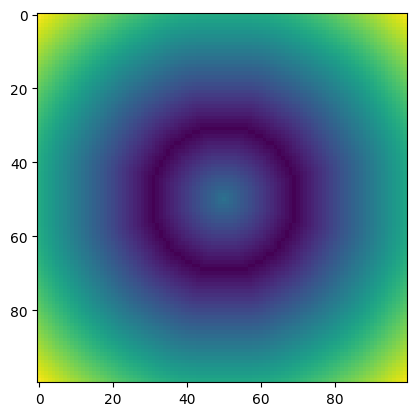

In [15]:
plt.imshow(im)
from scipy.ndimage import binary_erosion,distance_transform_edt
eroded = 1 - im ^ binary_erosion(im)
distances = distance_transform_edt(eroded, return_distances=True)
plt.imshow(distances)

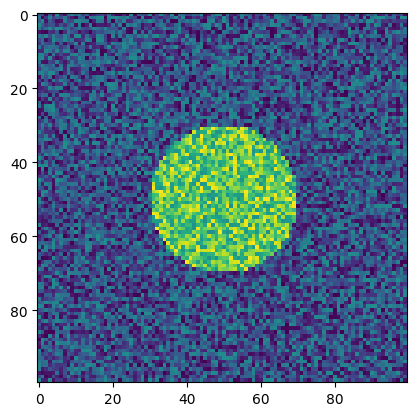

In [25]:
intensity = im+np.random.rand(100,100)
plt.imshow(intensity)

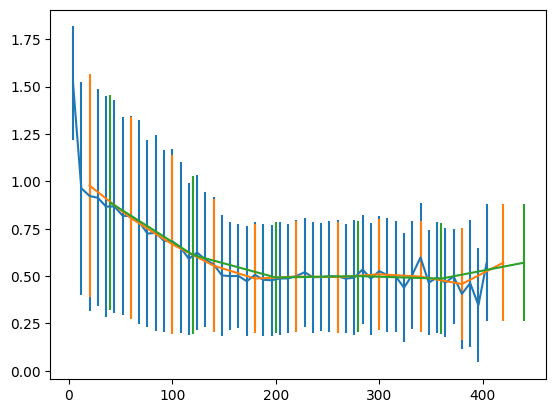

In [35]:
bin_size = 10
for bin_size in [1,5,10]:
    distance_bins = np.floor(distances/bin_size)
    # distance_bins is the number bin it is, 0th bin, 1st bin, 2nd bin etc but we want it in voxels or nm
    # 0th bin corresponds to 0-5 voxels distances for a 5 voxel bin size. and the 1st bin corresponds to 5-10 voxel distances
    # if you just multiply the bin by the bin size, you get the start of the bin. 0*5 = 0, 1*5 = 5. so if we add half the bin size back, we get it centered in the bin
    bins_in_voxels = np.unique(distance_bins)*bin_size+bin_size/2
    means = []
    stds = []
    for current_bin in np.unique(distance_bins):
        current_bin_intensities = intensity[distance_bins==current_bin]
        means.append(np.mean(current_bin_intensities))
        stds.append(np.std(current_bin_intensities))

    plt.errorbar(bins_in_voxels*8, means,stds)


In [30]:
bins_in_voxels

array([[52.5, 52.5, 47.5, ..., 47.5, 47.5, 52.5],
       [52.5, 47.5, 47.5, ..., 47.5, 47.5, 47.5],
       [47.5, 47.5, 47.5, ..., 47.5, 47.5, 47.5],
       ...,
       [47.5, 47.5, 47.5, ..., 47.5, 47.5, 47.5],
       [47.5, 47.5, 47.5, ..., 47.5, 47.5, 47.5],
       [52.5, 47.5, 47.5, ..., 47.5, 47.5, 47.5]])